## Setup

##### Mount Drive

In [ ]:
# Copyright (C) <2025>  <The Ohio State University>

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>;.

%reset -f
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Setup cobrapy

In [ ]:
pip install cobra==0.29.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 15.7 MB/s eta 0:00:00


In [ ]:
pip install gurobipy==11.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 44.8 MB/s eta 0:00:00


In [ ]:
import os

os.environ['GRB_LICENSE_FILE'] = '/content/drive/MyDrive/work/data/virocells/modeling-env/gurobi.lic'

In [ ]:
# Standard library imports
import os
import re
import math
import time
import csv
import pickle
import copy
from copy import deepcopy
from collections import defaultdict, deque

# Scientific and data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import TwoSlopeNorm
from scipy.interpolate import make_interp_spline
from scipy.spatial.distance import euclidean
from scipy.stats.mstats import gmean
from scipy.stats import linregress
import Levenshtein
import json
import ipywidgets as widgets
from IPython.display import display

# COBRA and metabolic modeling libraries
import cobra
from cobra.io import load_model, read_sbml_model, save_json_model
from cobra.flux_analysis import find_blocked_reactions
import sympy as sp
from optlang import Constraint
import gurobipy

In [ ]:
epsilon = np.finfo(float).eps # to keep from dividing by 0

##### Functions

In [ ]:
# @title
#sets fluxes through exchange reactions to 0
def no_intake(my_model):
    """
    Sets lower bounds of all exchange reactions to zero, preventing any metabolite uptake.

    This function creates a copy of the input model and modifies it by setting the
    lower bounds of all exchange reactions (those with 'EX_' prefix) to zero,
    effectively preventing the model from taking up any external metabolites.

    Parameters
    ----------
    my_model : cobra.Model
        The metabolic model to modify

    Returns
    -------
    cobra.Model
        A copy of the input model with exchange reaction lower bounds set to zero
    """
    my_model_1 = copy.deepcopy(my_model)

    for reaction in my_model_1.reactions:
        if 'EX_' in  reaction.id:
            reaction.lower_bound=0
    return my_model_1

def no_carbon_intake(my_model):
    """
    Sets lower bounds of carbon-containing exchange reactions to zero.

    This function creates a copy of the input model and modifies it by setting the
    lower bounds of exchange reactions for carbon-containing metabolites to zero,
    preventing uptake of carbon sources while allowing uptake of other nutrients.

    Parameters
    ----------
    my_model : cobra.Model
        The metabolic model to modify

    Returns
    -------
    cobra.Model
        A copy of the input model with carbon exchange reaction lower bounds set to zero
    """
    my_model_1 = copy.deepcopy(my_model)

    for reaction in my_model_1.reactions:
        if 'EX_' in  reaction.id:
          exchange_metabolite = my_model_1.metabolites.get_by_id("_".join(reaction.id.split("_")[1:]))
          if 'C' in exchange_metabolite.elements:
            reaction.lower_bound=0
    return my_model_1


def calculate_normalized_difference(x, y):
    """
    Calculates the normalized difference between two numbers.

    The normalized difference is defined as (x-y)/(|x|+|y|), which ranges from -1 to 1.
    Values close to zero indicate similarity, while values close to -1 or 1 indicate
    strong differences. This metric is useful for comparing flux values between models.

    Parameters
    ----------
    x : float
        First number
    y : float
        Second number

    Returns
    -------
    float
        Normalized difference between x and y, or 0 if x and y are very close
    """
    if abs(x-y) < 10**(-6):
      return 0
    else:
      return (x-y)/(abs(x)+abs(y)) #epsilon is a really tiny number of the order ~ 10^-16

def calculate_ratio(x, y):
    """
    Calculates the ratio between two numbers, handling division by zero.

    The ratio is calculated as x/y. To prevent division by zero errors,
    a small epsilon value is added to both numerator and denominator.

    Parameters
    ----------
    x : float
        Numerator
    y : float
        Denominator

    Returns
    -------
    float
        Ratio of x to y, with epsilon adjustment to prevent division by zero
    """
    return (x+epsilon)/(y+epsilon) # to keep from dividing by 0 if y is 0


def calculate_biomass_yields(wt_model, mu_model, biomass_yield_dict):
    """
    Calculates biomass yields for wild-type and mutant models using different methods.

    This function calculates the biomass flux for a wild-type model using parsimonious
    FBA (pFBA), and for a mutant model using both pFBA and MOMA (linear and quadratic).
    The results are stored in the provided dictionary under the 'biomass_reaction' key
    for later comparison and visualization.

    Parameters
    ----------
    wt_model : cobra.Model
        Wild-type metabolic model
    mu_model : cobra.Model
        Mutant metabolic model
    biomass_yield_dict : dict
        Dictionary to store the biomass yields results

    Returns
    -------
    None
        Results are stored in the biomass_yield_dict dictionary
    """
    def run_pfba(model):
        """Run parsimonious FBA on the given model."""
        return cobra.flux_analysis.pfba(model)

    def get_biomass_yield(solution):
        """Extract biomass yield from FBA solution."""
        biomass_rxn = bof_dict[model_name]
        return solution.fluxes[biomass_rxn]

    # --- Compute biomass yields with different methods ---
    # Wild-type pFBA
    pfba_wt_sol = run_pfba(wt_model)
    biomass_wt = get_biomass_yield(pfba_wt_sol)

    # Mutant pFBA
    pfba_mu_sol = run_pfba(mu_model)
    biomass_mu = get_biomass_yield(pfba_mu_sol)

    # Mutant linear MOMA
    moma_lin_sol = cobra.flux_analysis.moma(mu_model, solution=pfba_wt_sol, linear=True)
    biomass_moma_lin = get_biomass_yield(moma_lin_sol)

    # Mutant quadratic MOMA
    moma_nonlin_sol = cobra.flux_analysis.moma(mu_model, solution=pfba_wt_sol, linear=False)
    biomass_moma_nonlin = get_biomass_yield(moma_nonlin_sol)

    # Store biomass yields relative to wild-type
    biomass_yield_dict["biomass_reaction"].append([
        [biomass_wt, biomass_mu],
        [biomass_wt, biomass_moma_lin],
        [biomass_wt, biomass_moma_nonlin]
    ])

    return

def set_nutritional_environment(my_model, my_medium, condition=""):
    """
    Sets up the nutritional environment for a metabolic model by constraining intake fluxes.

    This function dispatches to the appropriate specialized function based on model type:
    - For E. coli models, it calls set_nutritional_environment_ecoli
    - For CBA models, it calls the CBA-specific implementation

    Parameters
    ----------
    my_model : cobra.Model
        The metabolic model to set up
    my_medium : str
        Path to the medium specification file
    condition : str, optional
        Condition specification, "_oxygen_limited" applies oxygen limitation

    Returns
    -------
    cobra.Model
        A copy of the input model with exchange reaction bounds set according to the medium
    """
    if "ecoli" in model_name:
        return set_nutritional_environment_ecoli(my_model, my_medium, condition)
    else:
        return set_nutritional_environment_cba(my_model, my_medium, condition)

def set_nutritional_environment_cba(my_model, my_medium, condition=""):
    """
    Sets up the nutritional environment for Cellulophaga baltica models by constraining intake fluxes.

    This function creates a copy of the metabolic model and sets bounds on exchange reactions
    according to the medium specification provided in the input file. For oxygen-limited
    conditions, it also constrains oxygen uptake to 80% of the maximum predicted by FBA.

    Parameters
    ----------
    my_model : cobra.Model
        The metabolic model to set up
    my_medium : str
        Path to the medium specification file
    condition : str, optional
        Condition specification, "_oxygen_limited" applies oxygen limitation

    Returns
    -------
    cobra.Model
        A copy of the input model with exchange reaction bounds set according to the medium
    """
    model = copy.deepcopy(my_model)
    model_reactions = [item.id for item in model.reactions]
    model = no_intake(model)

    with open(my_medium) as f:
        f.readline()
        for line in f:
            parts = line.split("\t")
            metabolite_id = parts[0]
            exchange_reaction = ["EX_" + metabolite_id + "_e0"]
            min_flux = abs(float(parts[3]))
            max_flux = abs(float(parts[4]))

            for rxn in exchange_reaction:
                if rxn in model_reactions:
                    model.reactions.get_by_id(rxn).bounds = (-max_flux, min_flux)
                else:
                    print(parts[1] + " exchange reaction not found in model")

    # Apply oxygen limitation after growth constraints
    if condition == "_oxygen_limited":
        fba_soln = cobra.flux_analysis.pfba(model)
        oxygen_uptake = 0.8 * fba_soln.fluxes["EX_cpd00007_e0"] # setting to 80% of maximum respiratory capacity predicted by FBA
        model.reactions.get_by_id("EX_cpd00007_e0").bounds = (oxygen_uptake, 100)

    return model

def set_nutritional_environment_ecoli(my_model, my_medium, condition=""):
    """
    Sets up the nutritional environment for E. coli models by constraining intake fluxes.

    This function handles the complexity of mapping ModelSEED metabolite IDs to BiGG IDs
    used in E. coli models. It creates a copy of the model, sets exchange reaction bounds
    according to the medium specification, and handles oxygen limitation if specified.

    Parameters
    ----------
    my_model : cobra.Model
        The E. coli metabolic model to set up
    my_medium : str
        Path to the medium specification file
    condition : str, optional
        Condition specification, "_oxygen_limited" applies oxygen limitation

    Returns
    -------
    cobra.Model
        A copy of the input model with exchange reaction bounds set according to the medium
    """
    model = copy.deepcopy(my_model)
    model_reactions = [item.id for item in model.reactions]
    model = no_carbon_intake(model)

    # Load translation model for mapping ModelSEED IDs to BiGG IDs
    translation_model = read_sbml_model(working_directory + "/models/CBA18_RAST_defined.xml")
    translation_model.solver.configuration.verbosity = 0
    translation_mets = [item.id for item in translation_model.metabolites]

    with open(my_medium) as f:
        f.readline()
        for line in f:
            parts = line.split("\t")

            # Map ModelSEED IDs to BiGG IDs for E. coli model
            if parts[0] + "_c0" in translation_mets:
                bigg_id = translation_model.metabolites.get_by_id(parts[0] + "_c0").annotation.get("bigg.metabolite", None)
                if isinstance(bigg_id, list):
                    exchange_reaction = ["EX_" + item + "_e" for item in bigg_id]
                elif isinstance(bigg_id, str):
                    exchange_reaction = ["EX_" + bigg_id + "_e"]
                else:
                    print(parts[1] + " does not map to a BiGG id in translation model")
                    continue
            elif parts[0] + "_e0" in translation_mets:
                bigg_id = translation_model.metabolites.get_by_id(parts[0] + "_e0").annotation.get("bigg.metabolite", None)
                if isinstance(bigg_id, list):
                    exchange_reaction = ["EX_" + item + "_e" for item in bigg_id]
                elif isinstance(bigg_id, str):
                    exchange_reaction = ["EX_" + bigg_id + "_e"]
                else:
                    print(parts[1] + " does not map to a BiGG id in translation model")
                    continue
            else:
                print(parts[1] + " does not map to a BiGG id in translation model")
                continue

            min_flux = abs(float(parts[3]))
            max_flux = abs(float(parts[4]))

            for rxn in exchange_reaction:
                if rxn in model_reactions:
                    model.reactions.get_by_id(rxn).bounds = (-max_flux, min_flux)
                else:
                    print(parts[1] + " exchange reaction not found in model")

    # Apply oxygen limitation after growth constraints
    if condition == "_oxygen_limited":
        fba_soln = cobra.flux_analysis.pfba(model)
        oxygen_uptake = 0.8 * fba_soln.fluxes["EX_o2_e"] # setting to 80% of maximum respiratory capacity predicted by FBA
        model.reactions.get_by_id("EX_o2_e").bounds = (oxygen_uptake, 100)

    return model

def process_quantitative_growth_data(file_name="growth_and_mutant_data/raw/quantitative_growth.tsv"):
    """
    Process growth rate data and calculate relative growth rates compared to wild-type.

    Reads growth data from TSV, calculates statistics, and normalizes to wild-type (Cba18).
    Results are saved to the growth_and_mutant_data/processed/ directory.
    """
    # Read and clean data
    df = pd.read_csv(file_name, sep="\t", dtype={'Strain_new_name': str})
    df['Strain_new_name'] = df['Strain_new_name'].replace(['1840', '1.84E+03'], '184e1')

    # Calculate statistics by group
    grouped_df = df.groupby(['Strain_new_name', 'C_source'])['r'].agg(['mean', 'std', 'count']).reset_index()
    grouped_df.columns = ['Strain_new_name', 'C_source', 'mean r', 'std r', 'count r']
    grouped_df['sem r'] = grouped_df['std r'] / np.sqrt(grouped_df['count r'])

    # Create pivot tables
    mean_df = grouped_df.pivot(index='Strain_new_name', columns='C_source', values='mean r')
    sem_df = grouped_df.pivot(index='Strain_new_name', columns='C_source', values='sem r')

    # Extract wild-type (Cba18) values for normalization
    cba18_mean = mean_df.loc['Cba18']
    cba18_sem = sem_df.loc['Cba18']

    # Calculate relative growth and propagate uncertainties
    relative_mean_df = mean_df.div(cba18_mean, axis=1)
    uncertainty_relative_mean_df = (sem_df / mean_df).add((cba18_sem / cba18_mean), axis=1) * relative_mean_df

    def save_tsv(df, filename):
      df.to_csv(filename, sep='\t', float_format='%.2f')

    # Save results to files
    save_tsv(mean_df, 'growth_and_mutant_data/processed/growth.tsv')
    save_tsv(sem_df, 'growth_and_mutant_data/processed/growth_uncertainty.tsv')
    save_tsv(relative_mean_df, 'growth_and_mutant_data/processed/relative_growth.tsv')
    save_tsv(uncertainty_relative_mean_df, 'growth_and_mutant_data/processed/relative_growth_uncertainty.tsv')

def abbreviate_pathways(pathway, length=30):
    """
    Truncate pathway names if they exceed a specified length.

    Used to shorten lengthy pathway names for better display in figures and tables.

    Parameters
    ----------
    pathway : str
        The pathway name to possibly abbreviate
    length : int, optional
        Maximum length before abbreviation, default 30

    Returns
    -------
    str
        Abbreviated pathway name with '...' suffix or the original if short enough
    """
    if len(pathway) > length:
        return pathway[:length] + '...'
    else:
        return pathway


def convert_RAST_to_bigg(my_model, my_dict):
    """
    Convert RAST model identifiers to BiGG identifiers.

    This function translates reaction IDs from the RAST annotation system to BiGG IDs
    by using the annotation information in the model. Useful for visualization with
    tools that require BiGG identifiers.

    Parameters
    ----------
    my_model : cobra.Model
        The model containing the reactions with BiGG annotations
    my_dict : dict
        Dictionary with RAST reaction IDs as keys and values to be mapped

    Returns
    -------
    dict
        Dictionary with BiGG reaction IDs as keys and the original values
    """
    bigg_dict = {}
    for rxn in my_model.reactions:
        bigg_reactions = rxn.annotation.get("bigg.reaction", rxn.id)

        if type(bigg_reactions) == list:
            for bigg_rxn in bigg_reactions:
                if bigg_rxn in bigg_dict: print("duplicate reaction. check manually for issues")
                bigg_dict[bigg_rxn] = my_dict[rxn.id]
        else:
            if bigg_reactions in bigg_dict: print("duplicate reaction. check manually for issues")
            bigg_dict[bigg_reactions] = my_dict[rxn.id]

    return bigg_dict

def remove_c0(my_dict):
    """
    Remove compartment suffix '_c0' from reaction/metabolite IDs in a dictionary.

    This function is used to simplify IDs for visualization or analysis where
    compartment information is not needed.

    Parameters
    ----------
    my_dict : dict
        Dictionary with keys that might contain '_c0' suffixes

    Returns
    -------
    dict
        Dictionary with '_c0' removed from all keys
    """
    return {key.replace("_c0", ""): my_dict[key] for key in my_dict.keys()}

def add_c0(my_dict):
    """
    Add cytosolic compartment suffix '_c0' to reaction IDs that need it.

    This function identifies reaction IDs that should have compartment information
    (those starting with 'rxn' or 'DM_cpd') and adds the cytosolic compartment
    suffix '_c0' if it's not already present.

    Parameters
    ----------
    my_dict : dict
        Dictionary with keys that might need '_c0' suffixes added

    Returns
    -------
    dict
        Dictionary with '_c0' added to appropriate keys
    """
    new_dict = {}
    for key in my_dict.keys():
        # Check if this is a reaction ID (starts with 'rxn') and doesn't already have a compartment suffix
        if (key.startswith('rxn') or key.startswith("DM_cpd") ) and not ('_c0' in key or '_e0' in key or '_' in key[3:]):
            # Add the '_c0' suffix
            new_dict[key + '_c0'] = my_dict[key]
        else:
            # Keep the key as is
            new_dict[key] = my_dict[key]
    return new_dict


def calculate_production(metabolite, model, flux_distribution):
    """
    Calculate the total production flux for a metabolite in a given flux distribution.

    This function determines how much of a metabolite is being produced across all
    reactions in the model by examining the stoichiometry and flux direction.
    Production occurs when a reaction with positive stoichiometry has positive flux,
    or when a reaction with negative stoichiometry has negative flux.

    Parameters
    ----------
    metabolite : str
        ID of the metabolite to calculate production for
    model : cobra.Model
        The metabolic model containing the reactions
    flux_distribution : dict
        Dictionary mapping reaction IDs to flux values

    Returns
    -------
    float
        Total production flux of the metabolite (mmol/gDW/h)
    """
    total_production = 0.0
    total_consumption = 0.0

    for reaction in model.reactions:
        flux = flux_distribution[reaction.id]
        stoichiometry = reaction.metabolites.get(model.metabolites.get_by_id(metabolite), 0)

        # Only include reactions where the metabolite is produced
        if (stoichiometry > 0 and flux > 0) or (stoichiometry < 0 and flux < 0):
            total_production += stoichiometry * flux

        #reaction were metabolite is consumed
        if (stoichiometry > 0 and flux < 0) or (stoichiometry < 0 and flux > 0):
            total_consumption += stoichiometry * flux

    if round(total_production, 5) != -1 * round(total_consumption, 5):
        print(f"production is {total_production} but consumption is {total_consumption} for {metabolite}")

    return total_production

## Collect Data

##### Load model

In [ ]:
#@title {display-mode: "form"}

#@markdown Threonine adolase is present in CBA18 but was not included in the KBase model. Adding it allows CBA18 to grow in glucose when the Phosphoglycerate dehydrogenase is knocked out which is consistent with experiments.

working_directory = "/content/drive/MyDrive/work/data/virocells/my_analysis/version_1/CBA_mutants"

os.chdir(working_directory)

model_name = "CBA18_RAST_defined" #@param ["CBA18_RAST_defined", "ecoli/iML1515"] {allow-input: false}

file_name = working_directory + "/models/" + model_name + ".xml"

model_0 = read_sbml_model(file_name)
model_0.solver.configuration.verbosity = 0

curation = "_add_threonine_adolase" #@param ["","_add_threonine_adolase"] {allow-input: false}

if curation == "_add_threonine_adolase":
  ecoli_RAST = read_sbml_model(working_directory + "/models/ecoli/ecoliRAST.xml")
  model_0.add_reactions([ecoli_RAST.reactions.get_by_id("rxn00541_c0")])
  model_0.reactions.get_by_id("rxn00541_c0").gene_reaction_rule = "M666_RS13845"

# make model similar to ecoli by adding constraint on ATP maintainance
if "ecoli" in model_name:
  model_0.reactions.get_by_id("ATPM").bounds = (0, 1000.0)
  #model_0.reactions.get_by_id("rxn00062_c0").bounds = (6.86, 1000.0) #this reaction is ATPM in ecoli model

model_0.optimize();

print("Model Name: " + model_name)

model_0


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2604132
Academic license 2604132 - for non-commercial use only - registered to ow___@buckeyemail.osu.edu


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Model Name: CBA18_RAST_defined


Name,
Memory address,7ee8876ed710
Number of metabolites,1200
Number of reactions,1295
Number of genes,848
Number of groups,0
Objective expression,1.0*bio1_biomass - 1.0*bio1_biomass_reverse_6e711
Compartments,"c0, e0"


##### Display information about mutants

In [ ]:
#@title {display-mode: "form"}

#@markdown This cell displays only when the the CBA18 model is loaded. Mutant genes include M666_RS15505, M666_RS13880 and M666_RS17370. They affect the following metabolic reactions:

#this is not ideal. you should automate the creation of this list
#mutant_reaction_eq = ["D-Glucosamine1-phosphate [c0] <=> D-Glucosamine phosphate [c0]", "D-mannose-6-phosphate [c0] <=> D-Mannose1-phosphate [c0]", "Acetyl-CoA [c0] + Glycine [c0] --> CoA [c0] + L-2-Amino-acetoacetate [c0]", "NAD [c0] + 3-Phosphoglycerate [c0] <=> NADH [c0] + H+ [c0] + 3-Phosphonooxypyruvate [c0]"]

reaction_gene_mapping = {"rxn01485_c0": "M666_RS15505", "rxn01329_c0": "M666_RS15505", "rxn00274_c0": "M666_RS13880", "rxn01101_c0":"M666_RS17370"}
if model_name != "ecoli/iML1515" and model_name != "ecoli/iJO1366":
  full_set_of_mutations = set(["M666_RS07700", "M666_RS16755", "M666_RS20120", "M666_RS18590", "M666_RS01685", "M666_RS02270", "M666_RS02280",
                          "M666_RS02275", "M666_RS15505", "M666_RS01050", "M666_RS01055", "M666_RS02285", "M666_RS15505", "M666_RS15505",
                          "M666_RS01425", "M666_RS01720", "M666_RS15505", "M666_RS08865", "M666_RS15505", "M666_RS13880", "M666_RS13880",
                          "M666_RS17370"])
  mutant_genes_in_model = full_set_of_mutations.intersection(set([i.id for i in model_0.genes]))

  mutant_reactions = ["rxn01485_c0", "rxn01329_c0", "rxn00274_c0", "rxn01101_c0"]


  mutant_info_dict = {"name": [model_0.reactions.get_by_id(i).name for i in mutant_reactions],
                      "has_flux": [abs(model_0.reactions.get_by_id(i).flux)>0 for i in mutant_reactions],
                      "gene": [model_0.reactions.get_by_id(i).gene_reaction_rule for i in mutant_reactions],
                      "BioCyc": [model_0.reactions.get_by_id(i).annotation["biocyc"] for i in mutant_reactions],
                      "KEGG": [model_0.reactions.get_by_id(i).annotation["kegg.reaction"] for i in mutant_reactions]}

  print("Metabolic Genes Impacted: " + ", ".join(list(mutant_genes_in_model)))
  display(pd.DataFrame(mutant_info_dict, index=mutant_reactions))

Metabolic Genes Impacted: M666_RS15505, M666_RS17370, M666_RS13880


,name,has_flux,gene,BioCyc,KEGG
rxn01485_c0,"D-Glucosamine 1-phosphate 1,6-phosphomutase [c0]",True,M666_RS15505,META:5.4.2.10-RXN,R02060
rxn01329_c0,"D-mannose 6-phosphate 1,6-phosphomutase [c0]",False,M666_RS15505,META:PHOSMANMUT-RXN,R01818
rxn00274_c0,Acetyl-CoA:glycine C-acetyltransferase [c0],False,M666_RS04130 and M666_RS13880,META:AKBLIG-RXN,R00371
rxn01101_c0,3-Phospho-D-glycerate:NAD+ 2-oxidoreductase [c0],True,M666_RS06810 and M666_RS17370 and M666_RS17960,META:PGLYCDEHYDROG-RXN,R01513


##### Read in quantitative growth data and other input data

In [ ]:
# @title
# relative growth rates
if model_name != "ecoli/iML1515":
  defined_mets = ["D-Glucose", "D-Lactose", "Maltose", "Sucrose", "D-Fructose", "L-Glutamic-acid", "Salicin"]
  defined_mets_wo_Salicin = ["D-Glucose", "D-Lactose", "Maltose", "Sucrose", "D-Fructose", "L-Glutamic-acid"]

else:
  defined_mets = ["D-Glucose", "D-Lactose", "Maltose", "D-Fructose", "L-Glutamic-acid"]
  defined_mets_wo_Salicin = defined_mets

# mapping mutant ids to reactions within the model that they affect
id_mapping = {"184a5": "rxn01485_c0", "181a6": "rxn01485_c0", "181a7": "rxn01485_c0",
              "184b1": "rxn01485_c0", "184c1": "rxn01485_c0", "184f1": "rxn01101_c0"}

process_quantitative_growth_data()

rel_growth = pd.read_csv("growth_and_mutant_data/processed/relative_growth.tsv", sep="\t", index_col=0)
rel_growth_unc = pd.read_csv("growth_and_mutant_data/processed/relative_growth_uncertainty.tsv", sep="\t", index_col=0)
abs_growth = pd.read_csv("growth_and_mutant_data/processed/growth.tsv", sep="\t", index_col=0)
abs_growth_unc = pd.read_csv("growth_and_mutant_data/processed/growth_uncertainty.tsv", sep="\t", index_col=0)

new_columns = {"D-glucose": "D-Glucose", "alpha-Lactose": "D-Lactose", "maltose": "Maltose", "sucrose": "Sucrose",
               "D-fructose": "D-Fructose", "L-glutamic acid": "L-Glutamic-acid", "salicin": "Salicin", "MLB":"LB_wo_glycine"}

rel_growth.rename(columns=new_columns, inplace=True)
rel_growth_unc.rename(columns=new_columns, inplace=True)
abs_growth.rename(columns=new_columns, inplace=True)
abs_growth_unc.rename(columns=new_columns, inplace=True)

rel_growth = rel_growth[defined_mets + ["LB_wo_glycine"]].loc[list(id_mapping.keys())]
rel_growth_unc = rel_growth_unc[defined_mets + ["LB_wo_glycine"]].loc[list(id_mapping.keys())]
abs_growth_wt = abs_growth[defined_mets + ["LB_wo_glycine"]].loc[["Cba18"]]
abs_growt_wt_unc = abs_growth_unc[defined_mets + ["LB_wo_glycine"]].loc[["Cba18"]]

#####################################################
#kegg annotations
kegg_reaction_module_dict = defaultdict(list)
kegg_module_reaction_dict = defaultdict(set)
kegg_module_description = {}
with open("../../tables/kegg/kegg_reaction_module.tsv", "r") as f:
  for line in f:
    reaction, module = line.strip("\n").split("\t")
    kegg_reaction_module_dict[reaction.strip("rn:")].append(module.strip("md:"))
    kegg_module_reaction_dict[module.strip("md:")].add(reaction.strip("rn:"))

with open("../../tables/kegg/kegg_modules.tsv", "r") as f:
  for line in f:
    module, description = line.strip("\n").split("\t")
    kegg_module_description[module] = description

kegg_annotations = {
    i.id: i.annotation["kegg.reaction"] if isinstance(i.annotation["kegg.reaction"], list)
          else [i.annotation["kegg.reaction"]]
    for i in model_0.reactions if "kegg.reaction" in i.annotation
}
kegg_reactions_in_model = set().union(*list(kegg_annotations.values()))

#####################################################
#biocyc annotations

metacyc_reaction_module_dict = defaultdict(list)
metacyc_module_reaction_dict = defaultdict(set)
metacyc_module_description = {}
with open("../../tables/metacyc/pathway_reactions.tsv", "r") as f:
  for line in f:
    module, reaction_string = line.strip("\n").split("\t")
    reactions = reaction_string.split(" // ")

    for rxn in reactions: metacyc_reaction_module_dict[rxn].append(module)
    metacyc_module_reaction_dict[module] = set(reactions)

with open("../../tables/metacyc/pathway_names.tsv", "r") as f:
  for line in f:
    module, description = line.strip("\n").split("\t")
    metacyc_module_description[module] = description

metacyc_annotations = {
    i.id: [j.strip("META:") for j in i.annotation['biocyc']] if isinstance(i.annotation['biocyc'], list)
          else [i.annotation['biocyc'].strip("META:")]
    for i in model_0.reactions if 'biocyc' in i.annotation
}
metacyc_reactions_in_model = set().union(*list(metacyc_annotations.values()))

##### Create mutant model

In [ ]:
#@title {display-mode: "form"}

#@markdown mutant with a hyphen use thresholds obtained from CBA18 experiment

#["LB-Marine", "LB-Marine_Glycine_Limited", "D-Glucose", "D-Lactose", "Maltose", "Sucrose", "D-Fructose", "L-Glutamic-acid", "Salicin", "combined_defined", "all_relevant", "LB", "LB-Argonne", "Glycine", "auxo_media", "Gelatin", "Iota-Carrageenan", "Casamino-acids"]
#carbon_source = "D-Glucose" #@param ["D-Glucose", "D-Lactose", "Maltose", "Sucrose", "D-Fructose", "L-Glutamic-acid", "Salicin", "LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]  {allow-input: false}

#["rxn01485_c0", "rxn01485_c0-181a7", "rxn01329_c0", "rxn00274_c0", "rxn01101_c0"]
CBA_mutant = "rxn01101_c0" #@param #["rxn01485_c0-181a7", "rxn01101_c0"] {allow-input: false}
media_condition = "_oxygen_limited" #@param ["", "_oxygen_limited"]
media_supplement = "" #@param ["", "_plus_formate"]


rast_to_bigg = {"rxn01485_c0":"PGAMT", "rxn01329_c0":"PMANM", "rxn00274_c0": "GLYAT", "rxn01101_c0": "PGCD"}

model_1 =  copy.deepcopy(model_0)
mutant_model = deepcopy(model_1)
wild_type_model = deepcopy(model_1)

if "ecoli" not in model_name: mutant_model.reactions.get_by_id(CBA_mutant).bounds = (0,0) #for CBA
else: mutant_model.reactions.get_by_id(rast_to_bigg[CBA_mutant]).bounds = (0,0) # for ecoli

Read LP format model from file /tmp/tmpgnh1k10q.lp
Reading time = 0.03 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpc47hrzis.lp
Reading time = 0.05 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpd8wxzucq.lp
Reading time = 0.05 seconds
: 1200 rows, 2590 columns, 11374 nonzeros


##### Extract metabolites in biomass objective

In [ ]:
# @title

bof_dict = {"CBA18_RAST_defined":"bio1_biomass", "ecoli/iML1515":"BIOMASS_Ec_iML1515_core_75p37M", "ecoli/iJO1366":"BIOMASS_Ec_iJO1366_core_53p95M"}
bof_to_mutant_rxns = {"bio1_biomass": list(rast_to_bigg.keys()), "BIOMASS_Ec_iML1515_core_75p37M": list(rast_to_bigg.values()), "BIOMASS_Ec_iJO1366_core_53p95M":list(rast_to_bigg.values())}

if model_name == "ecoli/iML1515":
  all_precursors = [met.id for met in model_1.reactions.get_by_id("BIOMASS_Ec_iML1515_core_75p37M").metabolites]

elif model_name == "ecoli/iJO1366":
  all_precursors = [met.id for met in model_1.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").metabolites]

else:
  macro_mols = {'DNA': 'cpd11461_c0', 'Protein': 'cpd11463_c0', 'mRNA': 'cpd11462_c0', 'Biomass':'cpd11416_c0'}
  make_macro = {'DNA': 'rxn05294_c0', 'Protein': 'rxn05296_c0', 'mRNA': 'rxn05295_c0', 'Biomass':'bio1_biomass'}

  biomass_mets_all = model_1.reactions.get_by_id("bio1_biomass").metabolites
  biomass_mets = {item:biomass_mets_all[item] for item in biomass_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  biomass_mets_ids = {item.id:(item.name, biomass_mets[item]) for item in biomass_mets.keys()}
  biomass_precursors = set(biomass_mets_ids.keys())

  # metabolites in mRNA synthesis reaction
  mRNA_mets_all = model_1.reactions.get_by_id("rxn05295_c0").metabolites
  mRNA_mets = {item:mRNA_mets_all[item] for item in mRNA_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  mRNA_mets_ids = {item.id:(item.name, mRNA_mets[item]) for item in mRNA_mets.keys()}
  mRNA_precursors = set(mRNA_mets_ids.keys())

  # metabolites in protein synthesis reaction
  prot_mets_all = model_1.reactions.get_by_id("rxn05296_c0").metabolites
  prot_mets = {item:prot_mets_all[item] for item in prot_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  prot_mets_ids = {item.id:(item.name, prot_mets[item]) for item in prot_mets.keys()}
  prot_precursors = set(prot_mets_ids.keys())

  # metabolites in DNA synthesis reaction
  DNA_mets_all = model_1.reactions.get_by_id("rxn05294_c0").metabolites
  DNA_mets = {item:DNA_mets_all[item] for item in DNA_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  DNA_mets_ids = {item.id:(item.name, DNA_mets[item]) for item in DNA_mets.keys()}
  DNA_precursors = set(DNA_mets_ids.keys())

  # small molecules that act as precursors for the production of macromolecules
  all_precursors = list(biomass_precursors | mRNA_precursors | prot_precursors | DNA_precursors)


##### Calculate biomass production yield

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

for met in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

    media_file =  f"growth_media/defined{media_supplement}/" + met + ".tsv"
    biomass_yield_dict = defaultdict(list)
    biomass_yield_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/biomass_yield/" + met.split("/")[-1] + "_" + CBA_mutant + media_condition + ".json"

    if save_new_tables == "yes" or (not os.path.exists(biomass_yield_file) and save_new_tables != "no"):
      wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)
      mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

      calculate_biomass_yields(wild_type_model_x, mutant_model_x, biomass_yield_dict)

      with open(biomass_yield_file, 'w') as f:
        json.dump(biomass_yield_dict, f)

##### Store flux data for escher visualization (the web version of escher only has maps for ecoli/iJO1366)

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

save_json_model(wild_type_model, working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/escher_fluxes/model.json")

for met in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

  media_file =  f"growth_media/defined{media_supplement}/" + met + ".tsv"
  escher_flux_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/escher_fluxes/" + met + "/" + CBA_mutant + media_condition

  if save_new_tables == "yes" or (not os.path.exists(escher_flux_file+ "_norm_diff.json") and save_new_tables != "no"):

    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)
    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

    # flux data for wild type
    wt_flux_data = dict(cobra.flux_analysis.pfba(wild_type_model_x).fluxes)
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_WT.json", 'w') as f:
        json.dump(remove_c0(wt_flux_data), f)
      with open(escher_flux_file + "_WT_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(wild_type_model_x, wt_flux_data), f)
    else:
      with open(escher_flux_file + "_WT.json", 'w') as f:
        json.dump(wt_flux_data, f)


    # flux data for mutant
    mu_flux_data_from_MOMA = dict(cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False).fluxes)
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_MU.json", 'w') as f:
        json.dump(remove_c0(mu_flux_data_from_MOMA), f)
      with open(escher_flux_file + "_MU_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(mutant_model_x, mu_flux_data_from_MOMA), f)
    else:
      with open(escher_flux_file + "_MU.json", 'w') as f:
        json.dump(mu_flux_data_from_MOMA, f)

    # difference in fluxes between the wild type and the mutant
    diff_flux_data = {key: mu_flux_data_from_MOMA[key] - wt_flux_data[key] for key in wt_flux_data.keys()}
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_diff.json", 'w') as f:
        json.dump(remove_c0(diff_flux_data), f)
      with open(escher_flux_file + "_diff_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(wild_type_model_x, diff_flux_data), f)
    else:
      with open(escher_flux_file + "_diff.json", 'w') as f:
        json.dump(diff_flux_data, f)


    # normalized difference in fluxes between wild_type and the mutant
    norm_diff_flux_data = {key:  calculate_normalized_difference(mu_flux_data_from_MOMA[key], wt_flux_data[key])  for key in wt_flux_data.keys()}
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_norm_diff.json", 'w') as f:
        json.dump(remove_c0(norm_diff_flux_data), f)
      with open(escher_flux_file + "_norm_diff_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(wild_type_model_x, norm_diff_flux_data), f)
    else:
      with open(escher_flux_file + "_norm_diff.json", 'w') as f:
        json.dump(norm_diff_flux_data, f)


##### Fluxes in WT vs Mutant

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

flux_file_diff = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + CBA_mutant + "_difference" + media_condition + ".json"
flux_file_norm_diff = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + CBA_mutant + "_normalized_difference" + media_condition + ".json"
flux_file_ratio = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + CBA_mutant + "_ratio" + media_condition + ".json"

flux_file_path_exists = os.path.exists(flux_file_diff) and os.path.exists(flux_file_norm_diff) and os.path.exists(flux_file_ratio)

rxn_fluxes_diff = defaultdict(list)
rxn_fluxes_norm_diff = defaultdict(list)
rxn_fluxes_ratio = defaultdict(list)

exchange_w_C = [i.id for i in wild_type_model.boundary if "C" in wild_type_model.metabolites.get_by_id("_".join(i.id.split("_")[1:])).elements]
exchange_all = [i.id for i in wild_type_model.boundary]
all_rxns = [i.id for i in wild_type_model.reactions]


if save_new_tables == "yes" or (not flux_file_path_exists and save_new_tables != "no"):
  rxn_fluxes_diff["all_rxns"] = rxn_fluxes_norm_diff["all_rxns"] = rxn_fluxes_ratio["all_rxns"] = all_rxns
  rxn_fluxes_diff["boundary"] = rxn_fluxes_norm_diff["boundary"] = rxn_fluxes_ratio["boundary"] = exchange_w_C
  rxn_fluxes_diff["internal"] = rxn_fluxes_norm_diff["internal"] = rxn_fluxes_ratio["internal"] = list(set(all_rxns) - set(exchange_all))

  for met in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:
    media_file =  f"growth_media/defined{media_supplement}/" + met + ".tsv"

    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)
    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)

    fba_solution_wt = cobra.flux_analysis.pfba(wild_type_model_x).fluxes

    fba_solution_mut = cobra.flux_analysis.pfba(mutant_model_x).fluxes
    moma_linear_soln = cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=True).fluxes
    moma_soln = cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False).fluxes

    for rxn in all_rxns:
      fba_diff = (fba_solution_mut[rxn]-fba_solution_wt[rxn])
      moma_linear_diff= (moma_linear_soln[rxn]-fba_solution_wt[rxn])
      moma_diff = (moma_soln[rxn]-fba_solution_wt[rxn])

      fba_norm_diff = calculate_normalized_difference(fba_solution_mut[rxn],fba_solution_wt[rxn])
      moma_linear_norm_diff= calculate_normalized_difference(moma_linear_soln[rxn],fba_solution_wt[rxn])
      moma_norm_diff = calculate_normalized_difference(moma_soln[rxn],fba_solution_wt[rxn])

      fba_ratio = calculate_ratio(fba_solution_mut[rxn],fba_solution_wt[rxn])
      moma_linear_ratio= calculate_ratio(moma_linear_soln[rxn],fba_solution_wt[rxn])
      moma_ratio = calculate_ratio(moma_soln[rxn],fba_solution_wt[rxn])

      rxn_fluxes_diff[met].append([fba_diff, moma_linear_diff, moma_diff])
      rxn_fluxes_norm_diff[met].append([fba_norm_diff, moma_linear_norm_diff, moma_norm_diff])
      rxn_fluxes_ratio[met].append([fba_ratio, moma_linear_ratio, moma_ratio])


  with open(flux_file_diff, 'w') as f:
    json.dump(rxn_fluxes_diff, f)

  with open(flux_file_norm_diff, 'w') as f:
    json.dump(rxn_fluxes_norm_diff, f)

  with open(flux_file_ratio, 'w') as f:
    json.dump(rxn_fluxes_ratio, f)


##### Cofactor and other metabolite production analysis

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

met_production_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/metabolite_production/" + CBA_mutant + media_condition + ".json"
met_production_dict = defaultdict(list)

all_metabolites = [i.id for i in model_0.metabolites]
met_production_dict["all_metabolites"] = all_metabolites
met_production_dict["frameworks"] = ["Wild Type FBA", "Mutant FBA", "Linear MOMA", "MOMA"]

if save_new_tables == "yes" or (not os.path.exists(met_production_file) and save_new_tables != "no"):

  for c_source in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

    media_file =  f"growth_media/defined{media_supplement}/" + c_source + ".tsv"

    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)
    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

    #mutant models
    fba_solution_wt = dict(cobra.flux_analysis.pfba(wild_type_model_x).fluxes)

    fba_solution_mut = dict(cobra.flux_analysis.pfba(mutant_model_x).fluxes)
    moma_linear_soln = dict(cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=True).fluxes)
    moma_soln = dict(cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False).fluxes)

    for met_id in all_metabolites:
      fba_wt_production = calculate_production(met_id, wild_type_model_x, fba_solution_wt)
      fba_mutant_production = calculate_production(met_id, mutant_model_x, fba_solution_mut)
      moma_linear_production = calculate_production(met_id, mutant_model_x, moma_linear_soln)
      moma_production = calculate_production(met_id, mutant_model_x, moma_soln)

      met_production_dict[c_source].append([fba_wt_production, fba_mutant_production, moma_linear_production, moma_production])

  with open(met_production_file, 'w') as f:
    json.dump(met_production_dict, f)

##### Write out blocked reactions, dead_end metabolites

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}


#reactions that cannot carry flux in the network
blocked_rxns_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/other/blocked_reactions.tsv"

# metabolites that cannot be produced or consumed by the network
dead_end_mets_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/other/dead_end_metabolites.tsv"

if save_new_tables == "yes" or (not os.path.exists(blocked_rxns_file) and save_new_tables != "no"):
  blocked_rxns = find_blocked_reactions(model_0, open_exchanges=True)

  dead_end_mets = [
      met for met in model_0.metabolites
      if met.reactions and all(rxn in blocked_rxns for rxn in [i.id for i in met.reactions])
  ]

  with open(dead_end_mets_file , 'w', newline='') as tsvfile:
      writer = csv.writer(tsvfile, delimiter='\t')
      writer.writerow(["metabolite_id", "metabolite_name"])
      for met in dead_end_mets:
          writer.writerow([met.id, met.name])

  with open(blocked_rxns_file , 'w', newline='') as tsvfile:
      writer = csv.writer(tsvfile, delimiter='\t')
      writer.writerow(["metabolite_id", "metabolite_name"])
      for rxn in blocked_rxns:
          writer.writerow([model_0.reactions.get_by_id(rxn).id, model_0.reactions.get_by_id(rxn).name])

##### Write out gapfilled reactions

In [ ]:
#@markdown Figure generated using gapfilling report (have to work on this)

save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

kbase_gapfilling_file = working_directory + "/models/gapfilling_reports/" + model_name + ".json"
gapfilling_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/other/gapfilling_reactions.tsv"

if (save_new_tables == "yes" or (not os.path.exists(gapfilling_file) and save_new_tables != "no")) and "ecoli" not in model_name:

  with open(kbase_gapfilling_file, "r") as f:
      data = json.load(f)
      gapfilling_report = pd.DataFrame(data)

  gapfilling_report[["reaction_id", "media", "gapfilling_sensitivity_id"]].to_csv(gapfilling_file, sep="\t", index=False)

  number_of_gapfilling_reactions = len(set(gapfilling_report["reaction_id"]))
  print("Number of gapfilling reactions: " + str(number_of_gapfilling_reactions))

##### Acetate secretion in Glucose

In [ ]:
# @title
media_file =  f"growth_media/defined{media_supplement}/D-Glucose.tsv"
#media_file =  f"growth_media/defined{media_supplement}/L-Glutamic-acid.tsv"
#media_file =  f"growth_media/defined{media_supplement}/LB/LB_wo_glycine.tsv"

wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition);
mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

fba_solution_wt = cobra.flux_analysis.pfba(wild_type_model_x).fluxes

cobra.flux_analysis.add_moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False)
mutant_model_x.optimize()
moma_soln = mutant_model_x.optimize().fluxes
wild_type_model_x.optimize()

if "ecoli" not in model_name:
  acetate_production_ratio = dict(moma_soln)["EX_cpd00029_e0"]/dict(fba_solution_wt)["EX_cpd00029_e0"]
else: acetate_production_ratio = dict(moma_soln)["EX_ac_e"]/dict(fba_solution_wt)["EX_ac_e"]

print("at 80% of the full respiratory capactiy, the acetate production ratio in the MU relative to the WT is " + str(acetate_production_ratio))

Read LP format model from file /tmp/tmpxbpvrlv3.lp
Reading time = 0.01 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpf9zn151f.lp
Reading time = 0.01 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpfc7rs008.lp
Reading time = 0.02 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpy62jy9_y.lp
Reading time = 0.01 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
at 80% of the full respiratory capactiy, the acetate production ratio in the MU relative to the WT is 1.2103567786677278


## Generate figures

#### Biomass production in Mutant vs WT

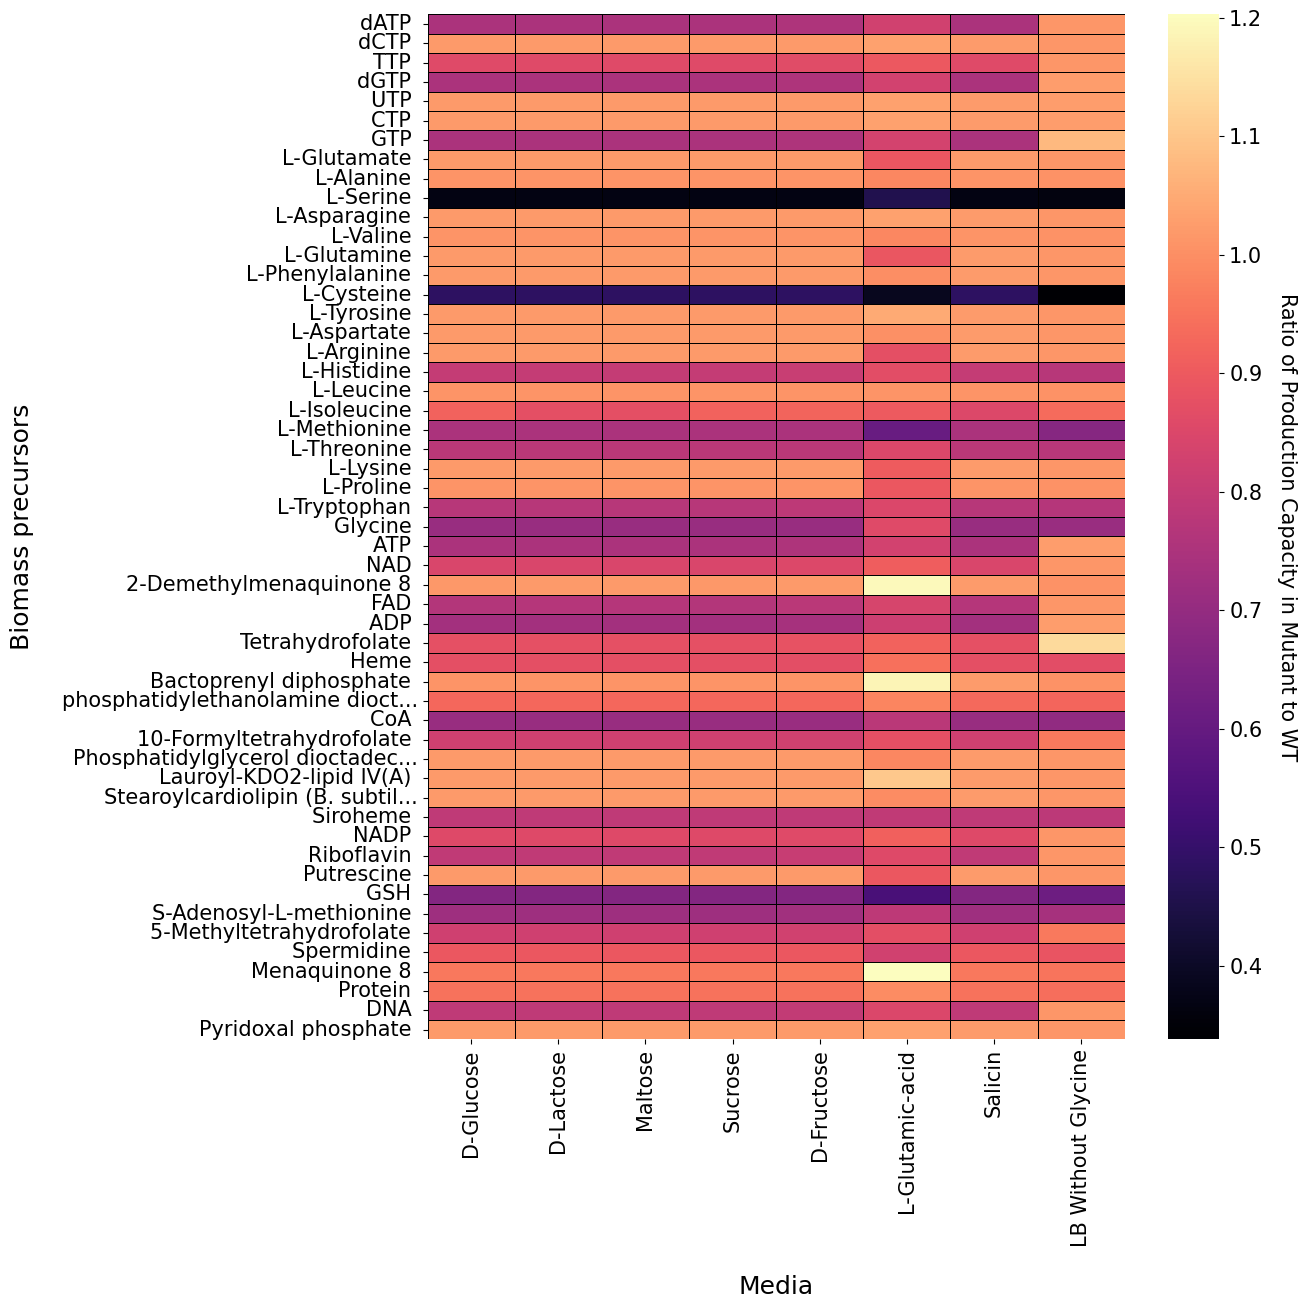

In [ ]:
#@markdown Heatmap showing the ratio of the production capacity of biomass precursors in mutant vs wild-type (can choose mutant)

KO_mutant = "rxn01101_c0" #@param ["rxn01101_c0"]{allow-input: false}
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

approach = "FBA"
approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}

media_list_map_0 = {"LB_wo_serine": "LB Without Serine", "LB_wo_glycine":"LB Without Glycine","LB_wo_threonine":"LB Without Threonine",
                  "LB_plus_serine": "LB Plus Serine", "LB_plus_glycine":"LB Plus Glycine", "LB_plus_threonine":"LB Plus Threonine"}


if create_figure == "yes":
  mutant_dict = {"rxn01101_c0": "phosphoglycerate dehydrogenase (M666_RS17370)"}

  media_list = defined_mets + ["LB_wo_glycine"] #+ ["LB_wo_serine", "LB_wo_threonine", "LB", "LB_plus_glycine", "LB_plus_serine", "LB_plus_threonine"]

  plot_dict = {}

  for item in media_list:
    max_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation+ "/max_precursors/" + item + "_" + KO_mutant + media_condition + ".json"
    with open(max_file, 'r') as f:
      plot_dict[item] = json.load(f)

  if "ecoli" not in model_name:
    unique_to_DNA = DNA_precursors - mRNA_precursors - prot_precursors - biomass_precursors
    unique_to_RNA = mRNA_precursors - DNA_precursors - prot_precursors - biomass_precursors
    unique_to_protein = prot_precursors - DNA_precursors - mRNA_precursors - biomass_precursors
    others = set(all_precursors) - unique_to_DNA - unique_to_RNA - unique_to_protein - {"cpd11416_c0"}
    precursor_list = list(unique_to_DNA) + list(unique_to_RNA) + list(unique_to_protein) + list(others) + ["biomass_reaction"]
  else: precursor_list = list(all_precursors) + ['biomass_reaction']

  filtered_precursors =[]
  data = []
  data_biomass = []
  precursors_not_produced = []

  for my_biomass_met in precursor_list:
    my_list = []
    my_list_for_wt = []

    for media in media_list:
      max_capacity = plot_dict[media][my_biomass_met][0] #there is a square bracket redundancy (e.g. [["1","2"]] to get rid of
      if max_capacity[0] == 0 and max_capacity[1] == 0: precursors_not_produced.append(my_biomass_met)

      # if my_biomass_met != 'biomass_reaction':
      #   mutant_to_wildtype_ratio  = (max_capacity[1]+epsilon)/(max_capacity[0]+epsilon)
      #   my_list.append(mutant_to_wildtype_ratio)
      # else:
      mutant_to_wildtype_ratio  = [(max_capacity[0][1]+epsilon)/(max_capacity[0][0]+epsilon),
                                    (max_capacity[1][1]+epsilon)/(max_capacity[1][0]+epsilon),
                                    (max_capacity[2][1]+epsilon)/(max_capacity[2][0]+epsilon)]
      if my_biomass_met != 'biomass_reaction': my_list.append(mutant_to_wildtype_ratio[approach_map[approach]])
      else: my_list.append(mutant_to_wildtype_ratio)

    #0.95 < element < 1.01
    if  my_biomass_met != 'biomass_reaction' and not any(element>10 for element in my_list) and not all(element==1 for element in my_list) and ('C' in model_0.metabolites.get_by_id(my_biomass_met).elements): #if the production capacity in wt and mutant differ by more than 1%
      filtered_precursors.append(my_biomass_met)
      data.append(my_list)
    if my_biomass_met == 'biomass_reaction':
      data_biomass.append(my_list)

  data_array_biomass = np.array(data_biomass).reshape(-1, 3).T
  data_array = np.array(data)

  col_names = [(media_list_map_0[item] if item in media_list_map_0 else item) for item in media_list] #media_list
  rows = filtered_precursors
  row_names = [abbreviate_pathways(model_1.metabolites.get_by_id(i).name.strip("[c0]")) for i in filtered_precursors]


  # Creating figure
  plt.figure(figsize=(14, 14))


  ax = sns.heatmap(data_array, annot=False, fmt=".2f", cmap='magma', cbar=True, linewidths=.5, linecolor='black',
              xticklabels=col_names, yticklabels=row_names, annot_kws={"size": 12}) #, vmin=0.5, vmax=1



  plt.xticks(rotation=90, fontsize = 15)#, fontweight='bold')
  plt.yticks(rotation=0, fontsize = 15)#, fontweight='bold')
  plt.xlabel("Media", fontsize=18, labelpad=20)#, fontweight='bold')
  plt.ylabel("Biomass precursors", fontsize=18, labelpad=20)#, fontweight='bold')
  #plt.title("Biomass Precursor Production in Wild Type vs Mutant\n[" + mutant_dict[KO_mutant]+"]", fontsize=18, pad=30)

  # Adjust color bar position and size
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=15)
  cbar.ax.set_ylabel('Ratio of Production Capacity in Mutant to WT', rotation=270, fontsize=15, labelpad=25)

  fig = plt.gcf()
  fig.tight_layout(pad=4.0)
  #figure_name = "figures/production_capacity_ratio/" + KO_mutant + model_name.replace("/","") + media_condition + ".svg"
  #plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()

Array saved as /content/drive/MyDrive/work/data/virocells/my_analysis/version_1/CBA_mutants/simulations/CBA18_RAST_defined_add_threonine_adolase/other/relative_growth_vs_predictions.tsv


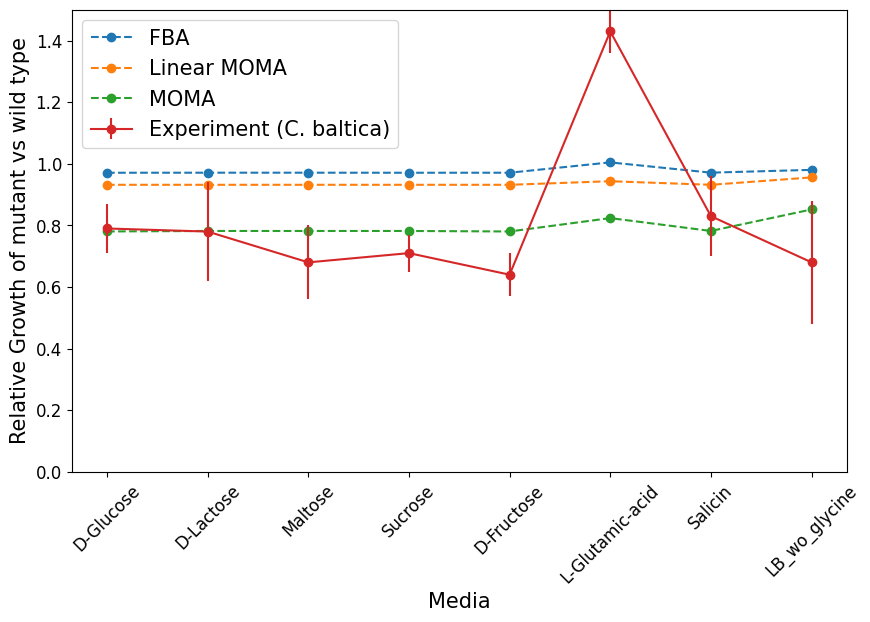

In [ ]:
# @title

#@markdown Line plot showing measured vs predicted relative growth

create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

if create_figure == "yes":
  plt.figure(figsize=(10, 6))

  if KO_mutant == "rxn01101_c0":
    growth_values = list(rel_growth[media_list].loc[list(id_mapping.keys())].loc["184f1"])
    growth_values_unc = list(rel_growth_unc[media_list].loc[list(id_mapping.keys())].loc["184f1"])
  elif KO_mutant == "rxn01485_c0-181a7":
    growth_values = list(rel_growth[media_list].loc[list(id_mapping.keys())].loc["181a7"])
    growth_values_unc = list(rel_growth_unc[media_list].loc[list(id_mapping.keys())].loc["181a7"])

  legend= ["FBA", "Linear MOMA", "MOMA"]

  for i, label in enumerate(legend):
    plt.plot(media_list, data_array_biomass[i], marker='o', label=label, linestyle='--')
  plt.errorbar(media_list, growth_values, yerr=growth_values_unc, marker='o', label="Experiment (C. baltica)")

  # data_array = np.append(data_array_biomass[:-1], [growth_values, growth_values_unc], axis=0)

  # Adding title and labels
  plt.xlabel('Media', fontsize = 15)
  plt.ylabel("Relative Growth of mutant vs wild type", fontsize=15)
  plt.xticks(rotation=45, fontsize = 12)
  plt.yticks(fontsize = 12)
  plt.ylim(0,1.5)
  plt.legend(fontsize =15)

  figure_name = "figures/relative_growth.svg"
  plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

#### Fluxes (Boundary and Internal) in Mutant vs WT

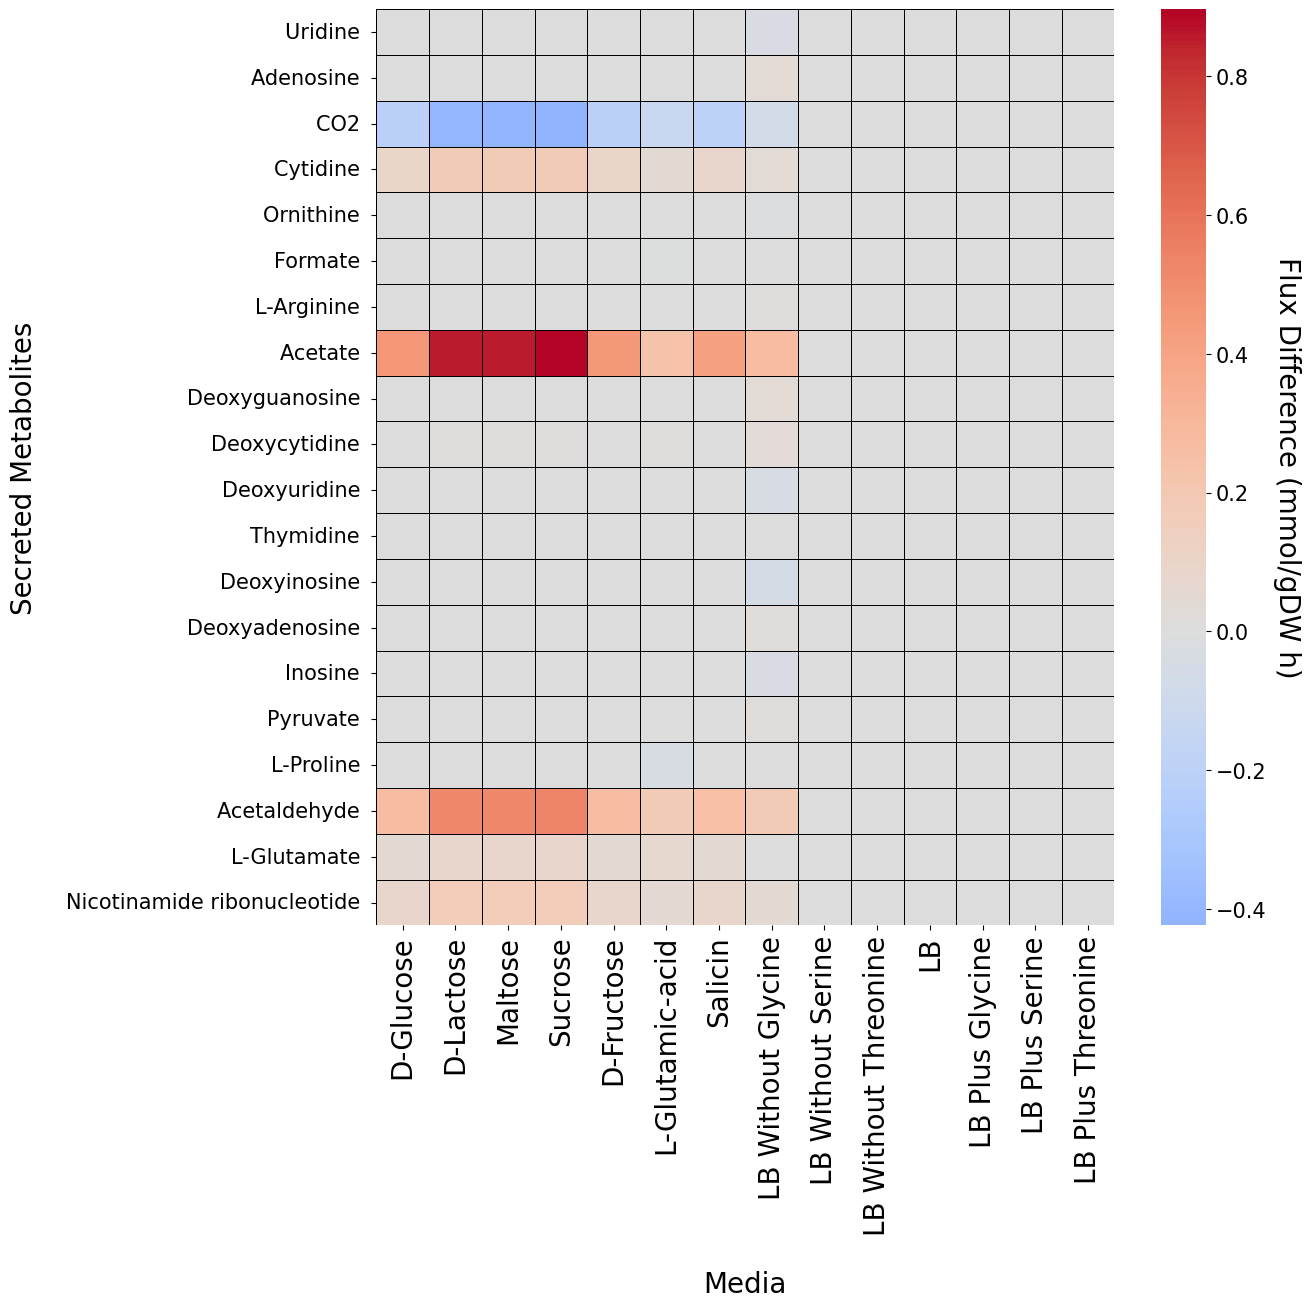

In [ ]:

#@markdown heatmap showing boundary fluxes in the wt vs mutant

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
metric = "difference" #@param ["difference", "normalized_difference", "ratio"] {allow-input: false}
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

compartment = "boundary"
approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}
media_list_map = {"D-Glucose":"D-Glucose", "LB/LB":"LB", "LB/LB_wo_serine": "LB Without Serine", "LB/LB_wo_glycine":"LB Without Glycine","LB/LB_wo_threonine":"LB Without Threonine",
                  "LB/LB_plus_serine": "LB Plus Serine", "LB/LB_plus_glycine":"LB Plus Glycine", "LB/LB_plus_threonine":"LB Plus Threonine"}

flux_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + mutant + "_" + metric + media_condition + ".json"
difference_flux_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + mutant + "_difference" + media_condition + ".json"

if create_figure == "yes":
  media_list = defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine", "LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  with open(flux_file, 'r') as f:
    plot_dict = json.load(f)

  with open(difference_flux_file, 'r') as f:
    helper_plot_dict = json.load(f)

  filtered_rxns =[]
  data = []

  for i in range(len(plot_dict["all_rxns"])):
    my_list = []
    my_helper_list = []
    for media in media_list:
      my_list.append(plot_dict[media][i][approach_map[approach]])
      my_helper_list.append(helper_plot_dict[media][i][approach_map[approach]])

    #if there is a difference between the WT and the mutant
    if not all(round(abs(element),5) == 0 for element in my_helper_list) and (plot_dict["all_rxns"][i] in plot_dict[compartment]):
      filtered_rxns.append(plot_dict["all_rxns"][i])
      data.append(my_list)

  data_array = np.array(data)

  col_names = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  rows = filtered_rxns
  row_names = [abbreviate_pathways(model_0.metabolites.get_by_id("_".join(i.split("_")[1:])).name.replace("[e0]","").replace("[c0]","")) for i in filtered_rxns]

  #Create Figure
  plt.figure(figsize=(14, 14))

  #norm = TwoSlopeNorm(vmin=data_array.min(), vcenter=0, vmax=data_array.max())

  ax = sns.heatmap(data_array, annot=False, fmt=".3f", cmap='coolwarm', center=0, cbar=True, linewidths=.5, linecolor='black',
              xticklabels=col_names, yticklabels=row_names, annot_kws={"size": 10})

  plt.xticks(rotation=90, fontsize = 20)#, fontweight='bold')
  plt.yticks(rotation=0, fontsize = 15)#, fontweight='bold')
  plt.xlabel("Media", fontsize=20, labelpad=25) #, fontweight='bold')
  plt.ylabel("Secreted Metabolites", fontsize=20, labelpad=20) #, fontweight='bold')

  # Adjust color bar position and size

  cbar = ax.collections[0].colorbar
  # cbar_ticks = [round(norm.vmin,1), round(norm.vcenter,1), round(norm.vmax,1)]
  # cbar.set_ticks(cbar_ticks)
  cbar.ax.tick_params(labelsize=15)
  if metric == "difference": cbar.ax.set_ylabel('Flux Difference (mmol/gDW h)', rotation=270, fontsize=20, labelpad=25)
  elif metric == "normalized_difference": cbar.ax.set_ylabel('Normalized Flux Difference', rotation=270, fontsize=20, labelpad=25)

  fig = plt.gcf()
  fig.tight_layout(pad=4.0)
  #figure_name = "figures/secretion_fluxes/" + mutant + model_name.replace("/","") + approach + compartment + ".svg"
  #plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()


<ipython-input-29-cf22a60cf0df>:55: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout(pad=4.0)


<Figure size 1400x1400 with 0 Axes>

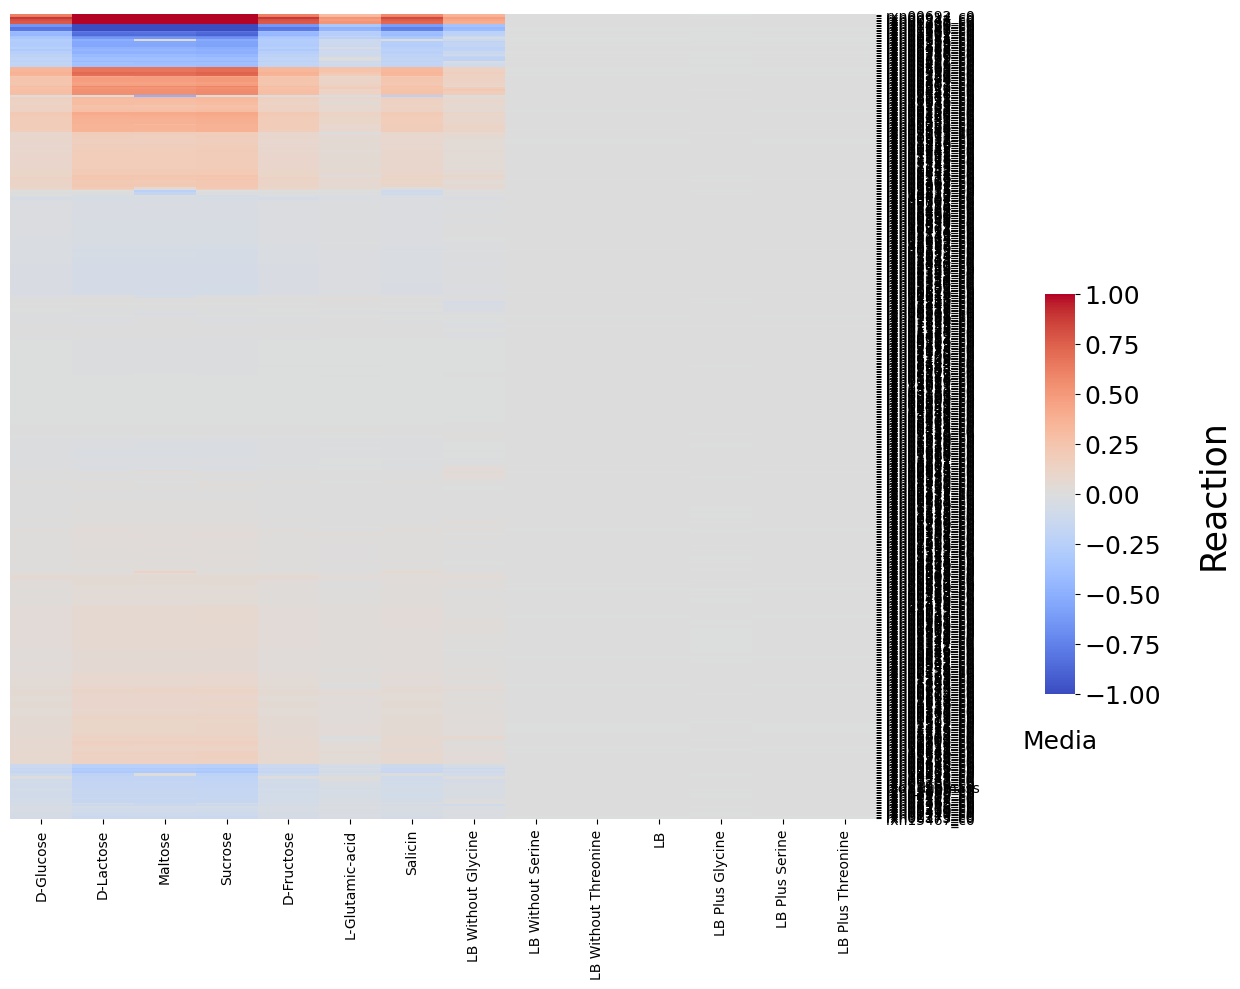

In [ ]:

#@markdown heatmap showing internal fluxes in the wt vs mutant

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
metric = "difference" #@param ["difference", "normalized_difference"] {allow-input: false}
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

compartment = "internal"
approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}

flux_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + mutant + "_" + metric + media_condition + ".json"

if create_figure == "yes":
  media_list = defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine", "LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  with open(flux_file, 'r') as f:
    plot_dict = json.load(f)

  filtered_rxns =[]
  data = []

  for i in range(len(plot_dict["all_rxns"])):
    my_list = []
    for media in media_list:
      internal_flux = plot_dict[media][i][approach_map[approach]]
      my_list.append(internal_flux)

    # if WT differes from mutant in any of the growth conditions
    if not all(round(abs(element),2) ==0 for element in my_list) and (plot_dict["all_rxns"][i] in plot_dict[compartment]):
      filtered_rxns.append(plot_dict["all_rxns"][i])
      data.append(my_list)

  data_array = np.array(data)

  col_names = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  rows = filtered_rxns
  row_names = filtered_rxns

  # Create Figure
  plt.figure(figsize=(14, 14))

  ax= sns.clustermap(data_array, annot=False, cmap='coolwarm', cbar_kws={'label': 'Flux (mmol/gDW h)'}, linewidths=0.0001,
                     linecolor='black', col_cluster=False, row_cluster=True, vmin=-1, vmax=1,
                     dendrogram_ratio=(0.0001, 0), cbar_pos=(1.05, 0.3, 0.03, 0.4), annot_kws={"size": 10},
                     xticklabels=col_names, yticklabels=row_names)

  plt.xticks(rotation=90, fontsize = 18) #, fontweight='bold')
  plt.yticks(rotation=0, fontsize = 18) #, fontweight='bold')
  plt.xlabel("Media", fontsize=18, labelpad=25) #, fontweight='bold')
  plt.ylabel("Reaction", fontsize=25, labelpad=25) #, fontweight='bold')

  fig = plt.gcf()
  fig.tight_layout(pad=4.0)
  #figure_name = "figures/secretion_fluxes/" + mutant + model_name.replace("/","") + approach + compartment + ".svg"
  #plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()


<Figure size 1800x1980 with 0 Axes>

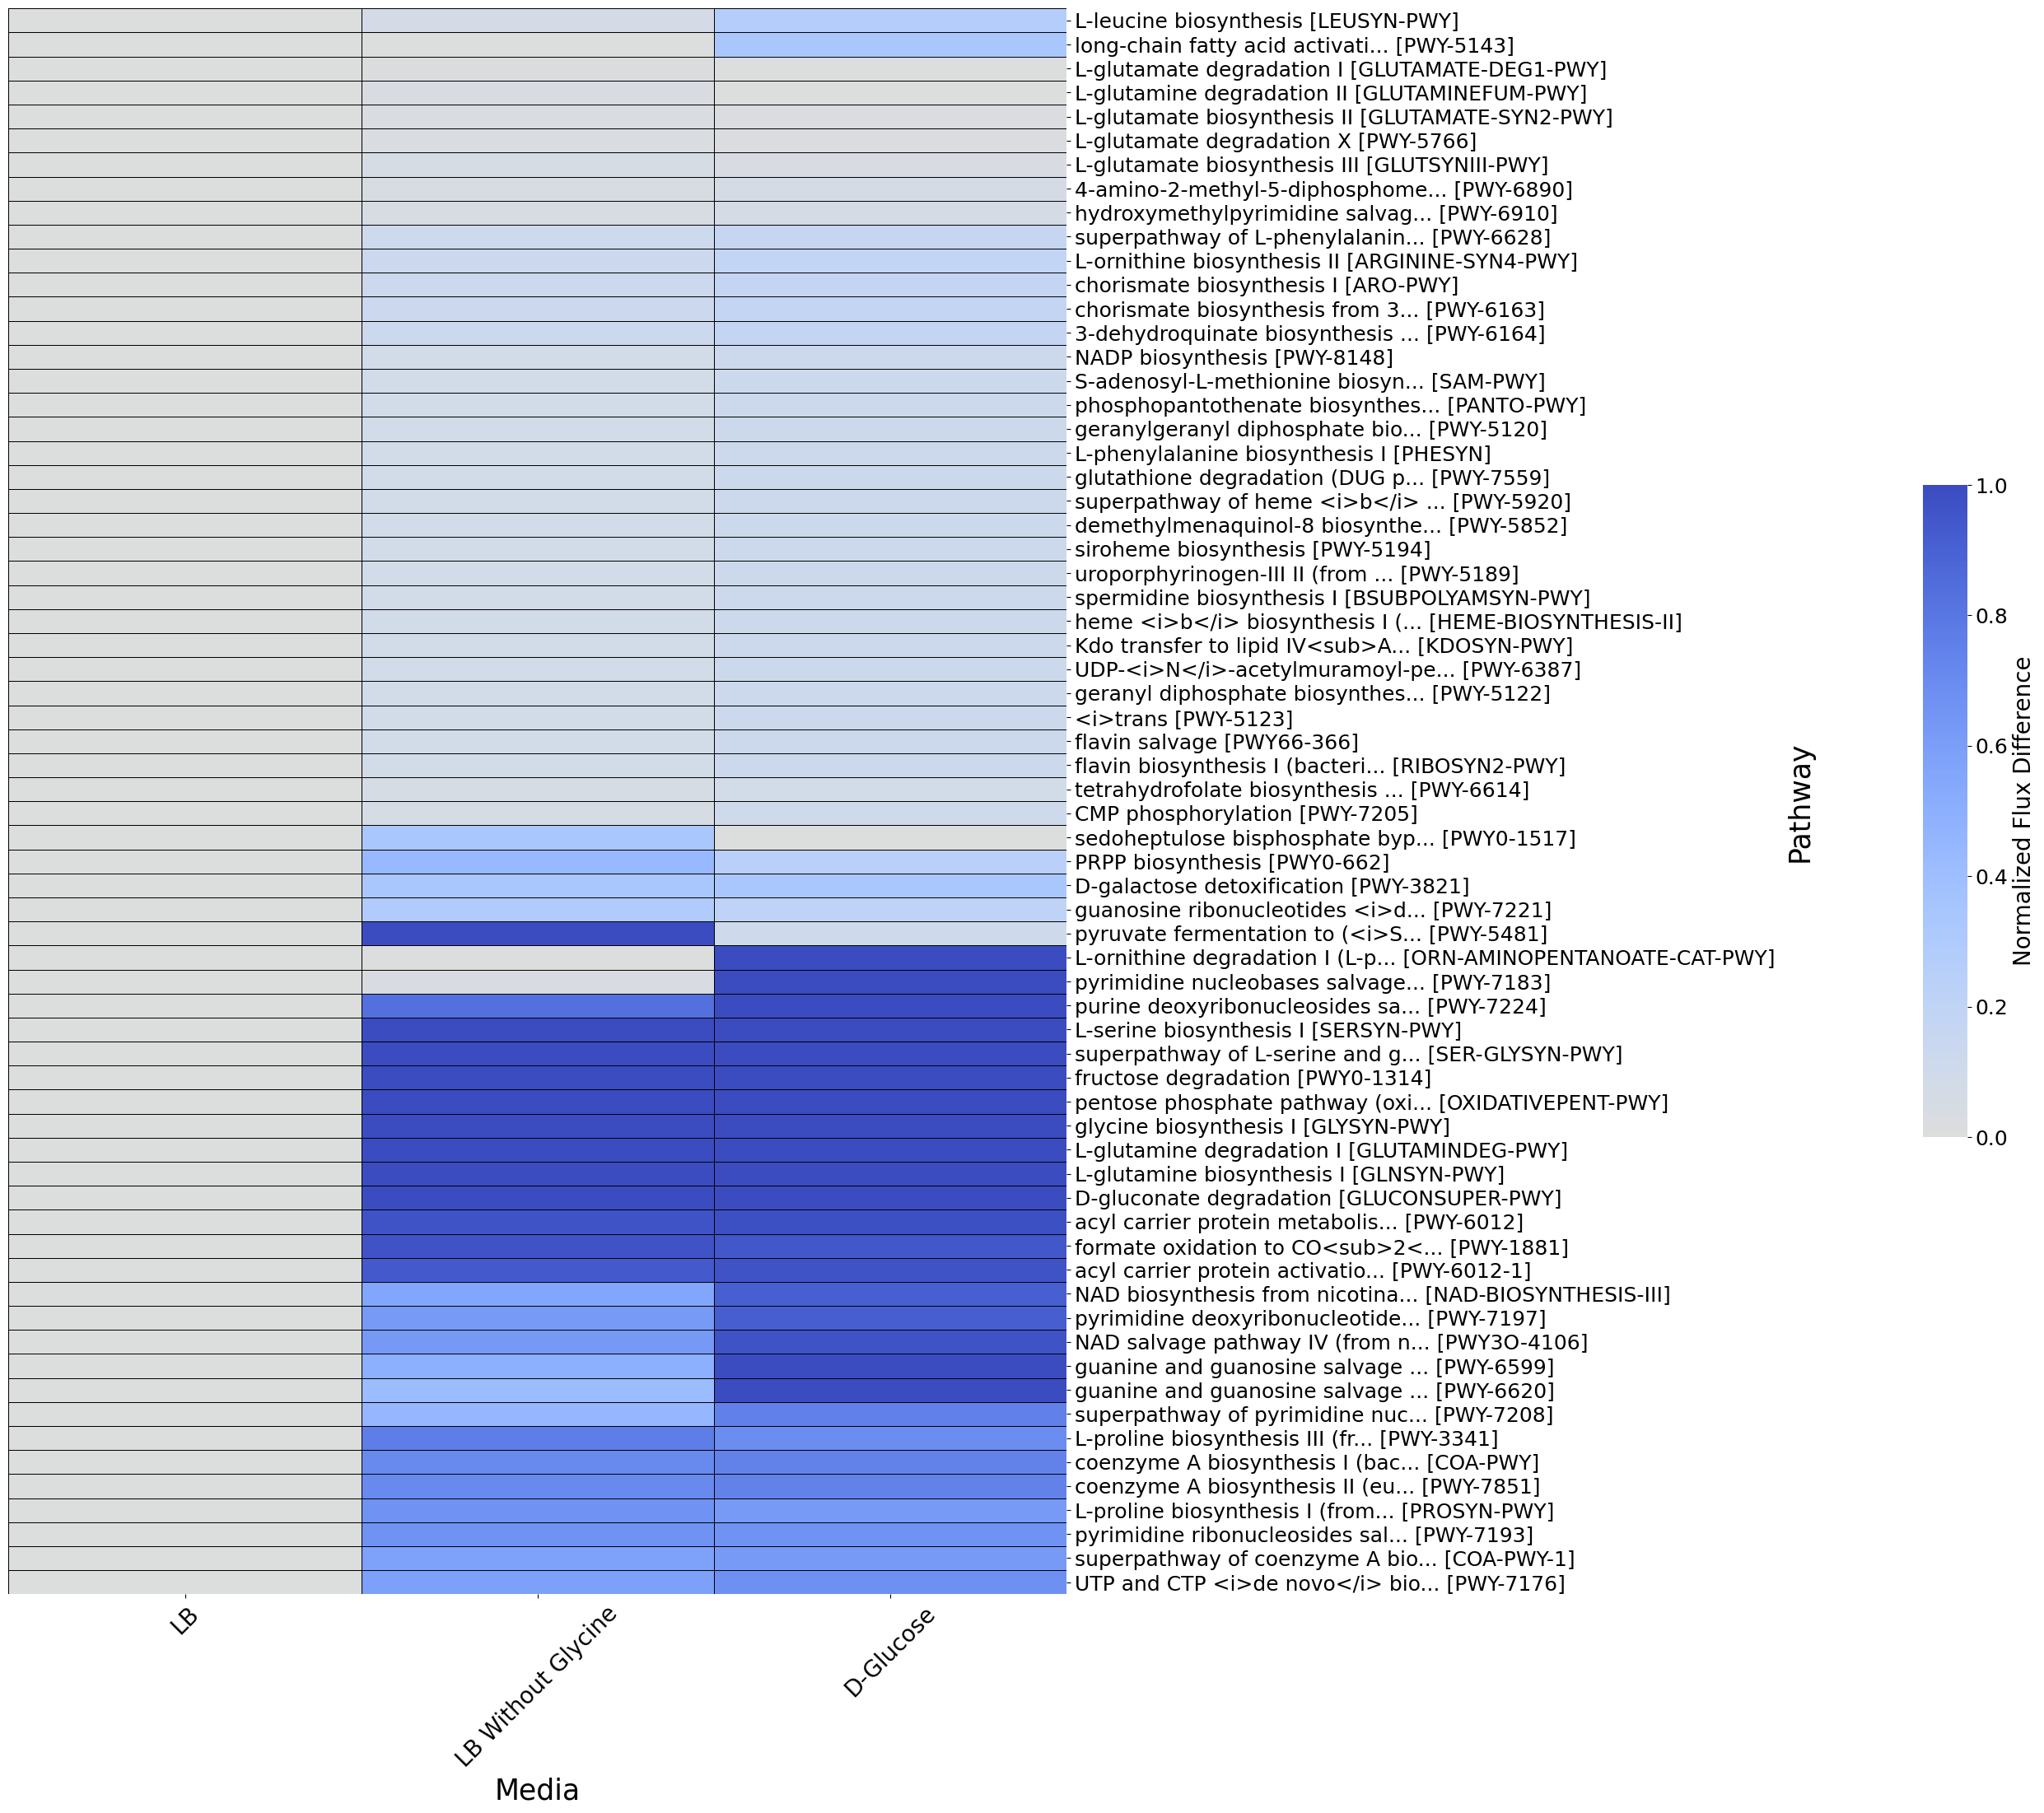

In [ ]:
#@markdown heatmap showing average fluxes in kegg or metacyc modules in WT vs mutant

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
difference_type = "_normalized_difference" #@param ["_difference", "_normalized_difference"] {allow-input: false}
metric = "mean_abs_diff" #@param ["mean_diff", "mean_abs_diff"] {allow-input: false}
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
database = "metacyc" #@param ["kegg", "metacyc"] {allow-input: false}
pathway_completeness = "1.0" #@param ["0.7", "1.0"] {allow-input: false}

approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}

#modules to be excluded because they have plant, archaea or eukaryotes in their description (the descriptions are in kegg_module_description or metacyc_module_description)
module_exclude_list = []#["M00365", "M00366", "M00367", "M00868", "M00580", "M00158", "M00160", "PWY-7851", "COA-PWY-1", "M00157", "M00159"]


if database == "kegg": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = kegg_reaction_module_dict, kegg_module_reaction_dict, kegg_module_description, kegg_annotations, kegg_reactions_in_model
elif database == "metacyc": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = metacyc_reaction_module_dict, metacyc_module_reaction_dict, metacyc_module_description, metacyc_annotations, metacyc_reactions_in_model

flux_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + mutant + difference_type + media_condition + ".json"

with open(flux_file, 'r') as f:
    plot_dict = json.load(f)

if create_figure == "yes":

  media_list =["LB/LB", "LB/LB_wo_glycine", "D-Glucose" ] # defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine", "LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  db_mod_dict = defaultdict(list)

  for i in range(len(plot_dict["all_rxns"])):
    seed_rxn = plot_dict["all_rxns"][i]

    if seed_rxn in db_annotations:
      for db_rxn in db_annotations[seed_rxn]:
        if db_rxn in db_reaction_module_dict:
          db_mods = db_reaction_module_dict[db_rxn]

          rxn_flux_list = []
          for media in media_list:
            rxn_flux = plot_dict[media][i][approach_map[approach]]
            rxn_flux_list.append(rxn_flux)

          for db_mod in db_mods:
            db_mod_dict[db_mod].append(rxn_flux_list)

  db_mod_dict = {key: db_mod_dict[key] for key in sorted(db_mod_dict)}
  filtered_db_mods =[]
  data = []

  for mod in db_mod_dict:

    # if metric=="normalized_difference": avg_for_db_mod = [round(np.mean(sublist),2)+0 for sublist in zip(*db_mod_dict[mod])]
    if metric == "mean_abs_diff": avg_for_db_mod = [np.mean([abs(i) for i in sublist]) for sublist in zip(*db_mod_dict[mod])] # average of absolute differences
    if metric == "mean_diff": avg_for_db_mod = [np.mean(sublist) for sublist in zip(*db_mod_dict[mod])] # average of differences

    total_rxns_in_module = len(db_module_reaction_dict[mod])
    those_present_in_model = len(db_module_reaction_dict[mod] & db_reactions_in_model)
    fraction_of_module_present = those_present_in_model/total_rxns_in_module

    # if the fluxes differ between the WT and the mutant
    if not all(round(abs(element),2) == 0 for element in avg_for_db_mod) and fraction_of_module_present >= float(pathway_completeness) and mod not in module_exclude_list:
      filtered_db_mods.append(mod)
      data.append(avg_for_db_mod)

  data_array = np.array(data)

  col_names = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  rows = filtered_db_mods
  row_names = [abbreviate_pathways(db_module_description[i].split(",")[0]) + " ["+i+"] " for i in rows] #

  #creating figure
  plt.figure(figsize=(18, max(14, len(filtered_db_mods)*0.3)))

  # ax = sns.clustermap(data_array, annot=False, cmap='coolwarm', linewidths=0.5,
  #                    linecolor='black', col_cluster=False, row_cluster=True, center=0,
  #                    dendrogram_ratio=(0.0001, 0), cbar_pos=(1.05, 0.3, 0.03, 0.4), annot_kws={"size": 10},
  #                    xticklabels=col_names, yticklabels=row_names)


  ax = sns.clustermap(data_array,
                    annot=False,
                    cmap='coolwarm_r',
                    linewidths=0.5,
                    linecolor='black',
                    col_cluster=False,
                    row_cluster=True,
                    center=0,
                    dendrogram_ratio=(0.0001, 0),  # Adjust for better proportions
                    cbar_pos=(1.3, 0.3, 0.03, 0.4),  # Reposition colorbar
                    xticklabels=col_names,
                    yticklabels=row_names,
                    figsize=(18, max(14, len(filtered_db_mods)*0.3)))  # Set figsize here too

  ax.ax_heatmap.set_xlabel('Media', fontsize = 25)
  ax.ax_heatmap.set_ylabel('Pathway', fontsize = 25 )
  ax.ax_heatmap.tick_params(axis='y', labelsize=18, rotation=0)
  ax.ax_heatmap.tick_params(axis='x', labelsize=20, rotation=45)

  cbar = ax.fig.axes[-1]  # Access the colorbar axis
  cbar.tick_params(labelsize=18)
  if  difference_type == "difference": cbar.set_ylabel('Flux Difference (mmol/gDW h)', fontsize=20)
  elif  difference_type == "_normalized_difference": cbar.set_ylabel('Normalized Flux Difference', fontsize=20)


  figure_name = "figures/pathway.svg"
  plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()


#### Metabolite Production (and consumption) in Mutant vs WT

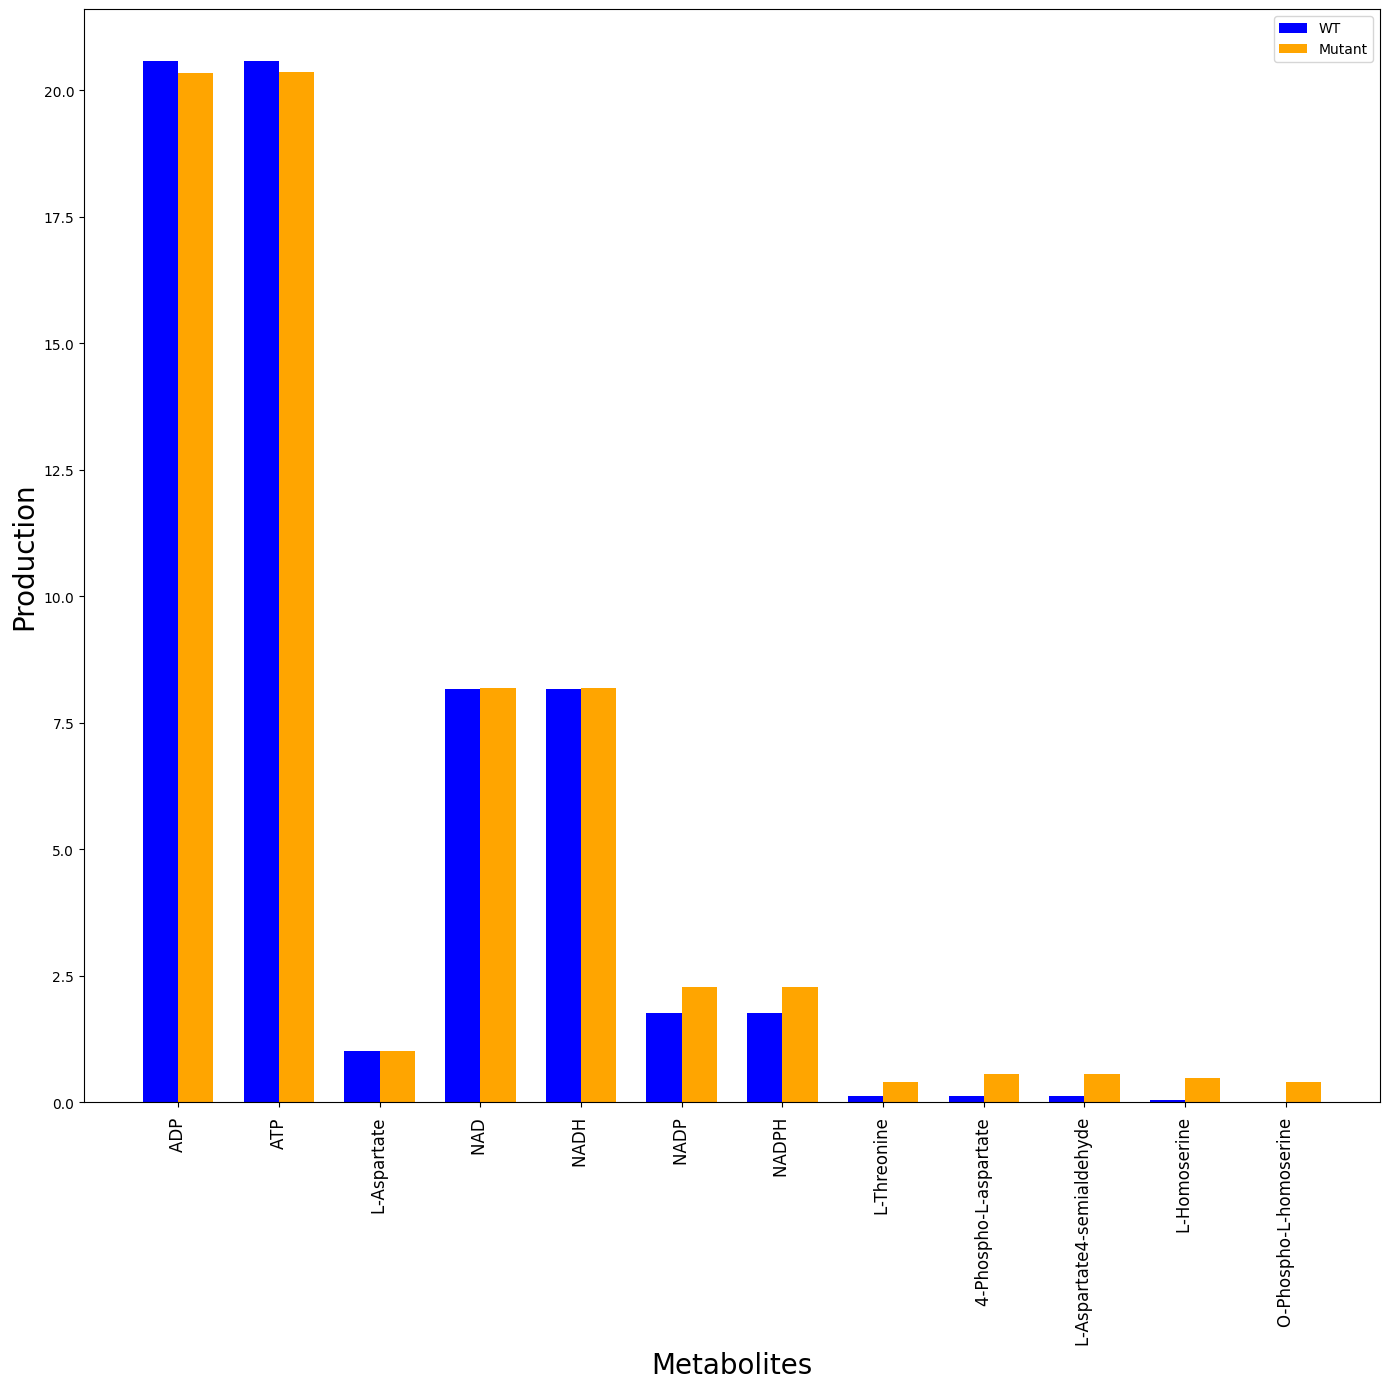

In [ ]:


#@markdown Bar chart the ratio of metabolite production in mutant vs wild-type

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
mutant_modeling_approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
pathway = "Threonine Biosynethesis" #@param ["Coenzyme A Biosynthesis", "Fatty Acid Biosynthesis", "Cysteine Biosynthesis", "Serine Biosynthesis", "Threonine Biosynethesis", "all"]
carbon_source = 'LB/LB_wo_glycine' #@param ['D-Glucose', 'D-Lactose', 'Maltose', 'Sucrose', 'D-Fructose', 'L-Glutamic-acid', 'Salicin', 'LB/LB', 'LB/LB_wo_serine', 'LB/LB_wo_glycine', 'LB/LB_wo_threonine', 'LB/LB_plus_serine', 'LB/LB_plus_glycine', 'LB/LB_plus_threonine']
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

approach_map = {"FBA": 1, "MOMA_linear": 2, "MOMA": 3}

metabolite_production_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/metabolite_production/" + CBA_mutant + media_condition + ".json"

with open(metabolite_production_file, 'r') as f:
  plot_dict = json.load(f)
met_list = plot_dict["all_metabolites"]

#obtain a list of all metabolites that are produced by the model under all tested conditions
media_list = defined_mets + ["LB/LB"] + ["LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]
all_mets_produced = set()
for met_id in met_list:
  met_index = met_list.index(met_id)
  for media in media_list:
    production_in_wt = plot_dict[media][met_index][0]
    production_in_mu = plot_dict[media][met_index][approach_map[mutant_modeling_approach]]
    if max(production_in_wt, production_in_mu) > 0:
      all_mets_produced.add(met_id)

metabolite_production = plot_dict[carbon_source]
met_list = plot_dict["all_metabolites"]

pathway_id_dict = {"Coenzyme A Biosynthesis": "M00120",
                  "Fatty Acid Biosynthesis": "M00082",
                  "Cysteine Biosynthesis": "M00021",
                  "Serine Biosynthesis": "M00020",
                  "Threonine Biosynethesis":"M00018"}
if pathway != "all":
  rxns_in_pathway = [key for key, value in kegg_annotations.items() if any(x in value for x in list(kegg_module_reaction_dict[pathway_id_dict[pathway]]))]
  mets_in_pathway = [j.id for j in list(set.union(*list(set(model_0.reactions.get_by_id(i).metabolites.keys()) for i in rxns_in_pathway))) if "C" in j.elements]
else: mets_in_pathway = all_mets_produced

#a figure showing the metabolite production ratios in the mutant relative to the wild type
if create_figure == "yes":

  plot_sub_dict = defaultdict(list)
  for i in range(len(met_list)):
    met_id = met_list[i]
    if (model_0.metabolites.get_by_id(met_id).compartment == "c" or model_0.metabolites.get_by_id(met_id).compartment == "c0") and (met_id in mets_in_pathway) and ('C' in model_0.metabolites.get_by_id(met_id).elements): #in list(key_metabolites.values()):
      production_in_wt = metabolite_production[i][0]
      production_in_mu = metabolite_production[i][approach_map[mutant_modeling_approach]]
      log_production_ratio = np.log(calculate_ratio(production_in_mu, production_in_wt))
      plot_sub_dict[met_id] = [production_in_wt, production_in_mu, log_production_ratio]
  plot_sub_dict = dict(sorted(plot_sub_dict.items(), key=lambda item: item[1][2], reverse=False))

  # Get the first 10 items
  top_x_metabolites = list(plot_sub_dict.items())[:50]

  # Extract keys, wt values, and mutant values
  met_names = [abbreviate_pathways(model_0.metabolites.get_by_id(item[0]).name.replace("[c0]","")) for item in top_x_metabolites]
  wt_values = [item[1][0] for item in top_x_metabolites]
  mutant_values = [item[1][1] for item in top_x_metabolites]
  log_ratio_values = [item[1][2] for item in top_x_metabolites]

  #creating figure
  plt.figure(figsize=(14, 14))

  x = range(len(met_names))  # Positions for the bars
  width = 0.35  # Width of the bars

  plt.bar(x, wt_values, width, label='WT', color='blue')
  plt.bar([i + width for i in x], mutant_values, width, label='Mutant', color='orange')
  #plt.bar(x, log_ratio_values, width, color='orange')

  #plt.bar([i + width for i in x], mutant_values, width, label='Mutant', color='orange')

  # Add labels and legend
  plt.xlabel('Metabolites', fontsize=20)
  plt.ylabel('Production', fontsize=20)
  #plt.xticks(x, met_names, rotation=90, fontsize = 12)  # Center the labels
  plt.xticks([i + width / 2 for i in x], met_names, rotation=90, fontsize = 12)  # Center the labels
  plt.yticks(rotation=0, fontsize =10)
  plt.legend()

  # Show the plot
  plt.tight_layout()
  plt.show()



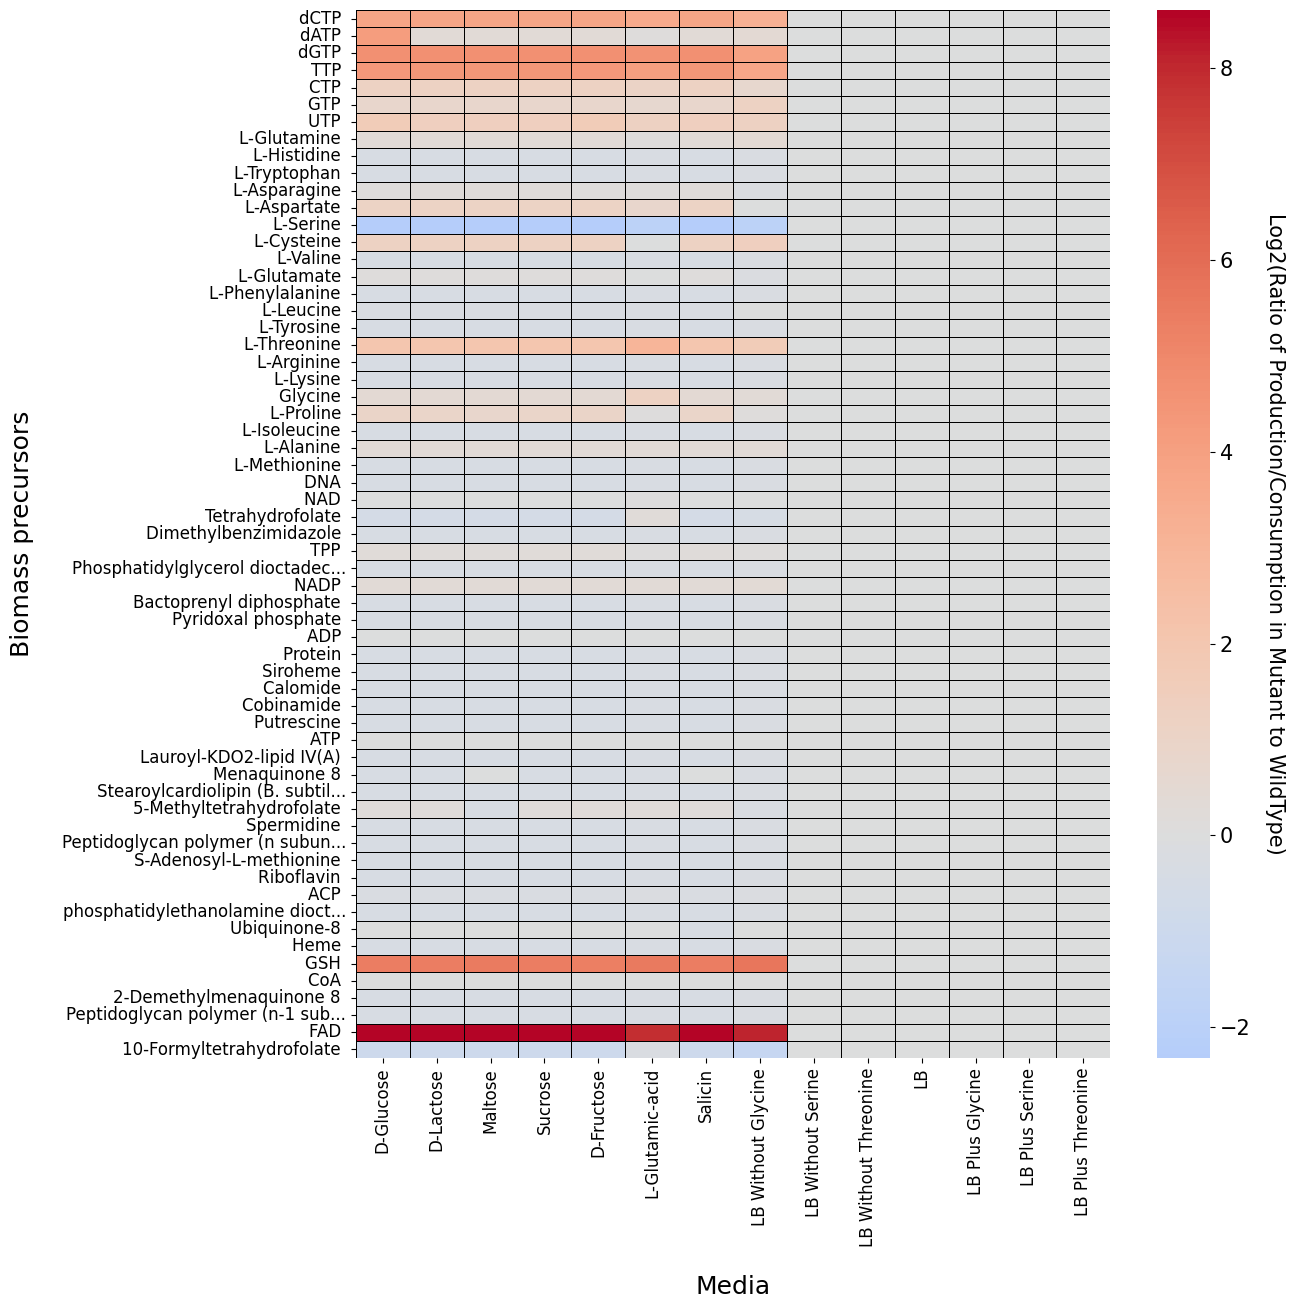

In [ ]:
#@markdown Heatmap showing the log ratio of metabolite production in mutant vs wild-type for metabolites in the biomass function.

KO_mutant = "rxn01101_c0" #@param ["rxn01101_c0"]{allow-input: false}

create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
mutant_modeling_approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
metabolite_production_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/metabolite_production/" + CBA_mutant + media_condition + ".json"


with open(metabolite_production_file, 'r') as f:
  plot_dict = json.load(f)
met_list = plot_dict["all_metabolites"]

if create_figure == "yes":
  media_list = defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine", "LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  if "ecoli" not in model_name:
    unique_to_DNA = DNA_precursors - mRNA_precursors - prot_precursors - biomass_precursors
    unique_to_RNA = mRNA_precursors - DNA_precursors - prot_precursors - biomass_precursors
    unique_to_protein = prot_precursors - DNA_precursors - mRNA_precursors - biomass_precursors
    others = set(all_precursors) - unique_to_DNA - unique_to_RNA - unique_to_protein - {"cpd11416_c0"}
    precursor_list = list(unique_to_DNA) + list(unique_to_RNA) + list(unique_to_protein) + list(others) + ["cpd11416_c0"]
  else: precursor_list = list(all_precursors)

  filtered_precursors =[]
  data = []

  for my_biomass_met in precursor_list:
    log_ratio_list = []
    ratio_list = []
    met_index = met_list.index(my_biomass_met)

    for media in media_list:
      metabolite_production = plot_dict[media]
      production_in_wt = metabolite_production[met_index][0]
      production_in_mu = metabolite_production[met_index][approach_map[mutant_modeling_approach]]

      production_ratio = calculate_ratio(production_in_mu, production_in_wt)
      log_production_ratio = np.log2(production_ratio)

      ratio_list.append(production_ratio)
      log_ratio_list.append(log_production_ratio)

    #if not all(0.99 < element < 1.01 for element in ratio_list) and "C" in model_0.metabolites.get_by_id(my_biomass_met).elements and (my_biomass_met in all_mets_produced): #if the production capacity in wt and mutant differ by more than 1%
    #if not all(abs(element)<np.log2(1.5) for element in log_ratio_list) and "C" in model_0.metabolites.get_by_id(my_biomass_met).elements and (my_biomass_met in all_mets_produced):
    if not all(abs(element)== 1 for element in ratio_list) and "C" in model_0.metabolites.get_by_id(my_biomass_met).elements and (my_biomass_met in all_mets_produced):
      filtered_precursors.append(my_biomass_met)
      data.append(log_ratio_list)

  data_array = np.array(data)

  col_names = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  rows = filtered_precursors
  row_names = [abbreviate_pathways(model_0.metabolites.get_by_id(i).name.replace("[c0]","")) for i in filtered_precursors]


  # Creating figure
  plt.figure(figsize=(14, 14))

  ax = sns.heatmap(data_array, annot=False, fmt=".2f", cmap='coolwarm', center=0, cbar=True, linewidths=.5,
                   linecolor='black', xticklabels=col_names, yticklabels=row_names, annot_kws={"size": 12})


  plt.xticks(rotation=90, fontsize = 12)#, fontweight='bold')
  plt.yticks(rotation=0, fontsize = 12)#, fontweight='bold')
  plt.xlabel("Media", fontsize=18, labelpad=20)#, fontweight='bold')
  plt.ylabel("Biomass precursors", fontsize=18, labelpad=20)#, fontweight='bold')
  #plt.title("Biomass Precursor Production in Wild Type vs Mutant\n[" + mutant_dict[KO_mutant]+"]", fontsize=18, pad=30)

  # Adjust color bar position and size
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=15)
  cbar.ax.set_ylabel('Log2(Ratio of Production/Consumption in Mutant to WildType)', rotation=270, fontsize=15, labelpad=25)

  fig = plt.gcf()
  fig.tight_layout(pad=4.0)
  #figure_name = "figures/production_capacity_ratio/" + KO_mutant + model_name.replace("/","") + media_condition + ".svg"
  #plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()


#### Gapfilling reactions

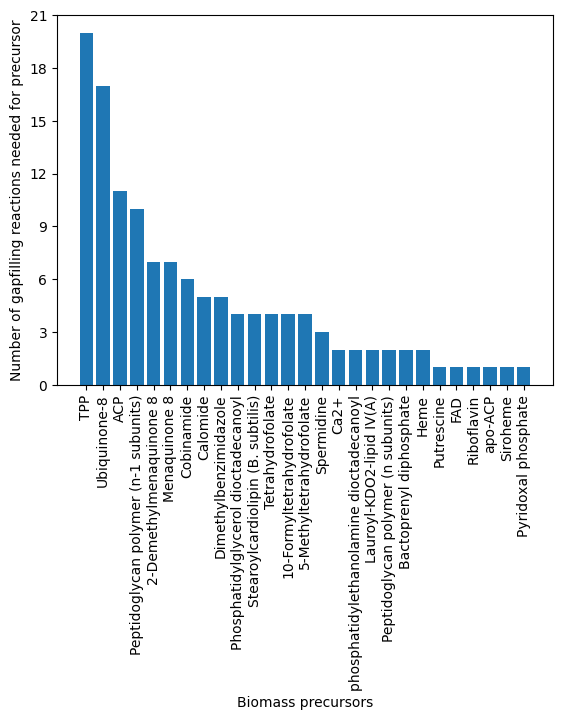

In [ ]:
#@markdown Metabolites that required gapfilling reactions but are not in mRNA, protein and DNA (candidates for removal from biomass function)
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

if create_figure == "yes" and "ecoli" not in model_name:
  gapfilling_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/other/gapfilling_reactions.tsv"
  gapfilling_report = pd.read_csv(gapfilling_file, sep="\t")
  essential_precursors = mRNA_precursors | prot_precursors | DNA_precursors

  gap_filling_sensitivity = [item.split("; ") for item in list(gapfilling_report["gapfilling_sensitivity_id"])]

  count_biomass_mets = defaultdict(int)
  for sublist in gap_filling_sensitivity:
    if len(set(sublist) & essential_precursors) > 0:
      continue
    for item in sublist:
      count_biomass_mets[item] += 1


  count_biomass_mets = dict(count_biomass_mets)

  # Sort the dictionary
  count_biomass_mets = dict(sorted(count_biomass_mets.items(), key=lambda item: item[1], reverse=True))
  biomass_met_names = [model_0.metabolites.get_by_id(id).name.strip(" [c0]") for id in count_biomass_mets.keys()]

  # Plotting the bar plot
  plt.bar(biomass_met_names, count_biomass_mets.values())
  plt.xlabel('Biomass precursors')
  plt.xticks(rotation=90)
  plt.ylabel('Number of gapfilling reactions needed for precursor')
  plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

  # figure_name = "figures/gapfilling_analysis/" + KO_mutant
  # plt.savefig(figure_name, dpi=1000, bbox_inches="tight")

  plt.show()